# GENOVA: explore the Hi-Cs
> 从此处摘抄、翻译、理解和应用
>
> https://github.com/robinweide/GENOVA
>
> 原作者如下

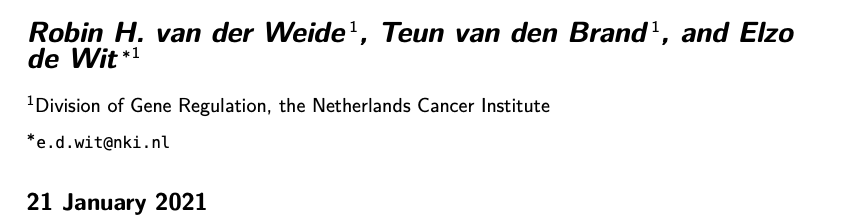

<!-- ![](https://p.ipic.vip/2sacdy.png) -->

## Abstract
> The increase in interest for Hi-C methods in the chromatin community has led to a need for more user-friendly and powerful analysis methods. The few currently available software packages for Hi-C do not allow a researcher to quickly summarize and visualize their data. An easy to use software package, which can generate a comprehensive set of publication-quality plots, would allow researchers to swiftly go from raw Hi-C data to interpretable results. 
>
> Here, we present **GEN**ome **O**rganisation **V**isual **A**nalytics (GENOVA): 
> - a software suite to perform in-depth analyses on various levels of genome organisation, using Hi-C data. GENOVA facilitates the comparison between multiple datasets and supports the majority of mapping-pipelines.

染色质界对Hi-C方法兴趣的增加导致了对更多用户友好和强大分析方法的需求。目前为数不多的Hi-C软件包并不允许研究人员快速总结和可视化他们的数据。一个易于使用的软件包，能够生成一套全面的、具有出版质量的图表，将使研究人员能够迅速地从原始Hi-C数据到可解释的结果。

在这里，我们提出了**基因**组**组织**视觉**分析（GENOVA）:
- 这套软件可以利用Hi-C数据对基因组组织的各个层面进行深入分析。GENOVA促进了多个数据集之间的比较，并支持大多数的绘图管道。


## Install / Load packages

In [1]:
# install.packages("remotes")

# remotes::update_packages()
# 1: All

# remotes::install_github("robinweide/GENOVA")

# if use juicer and .hic file
# remotes::install_cran("strawr")

# if use get_test_data
# remotes::install_cran("pkgfilecache")


# for plot figure theme
# remotes::install_cran('ggthemes', dependencies = TRUE)
# remotes::install_cran('ggprism', dependencies = TRUE)
# remotes::install_cran('cowplot', dependencies = TRUE)


In [1]:
library(GENOVA)
library(tidyverse)
library(ggprism)
library(cowplot)
library(strawr)

── Attaching packages ──────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::resolution() masks GENOVA::resolution()


## Quickstart for test
If you want to take GENOVA for a spin or compare outputs, we have included some optional test data at 40k and 150k resolution of just two smaller human chromosomes. You can find more details about the data itself in the `?get_test_data` documentation. The `get_test_data()` function downloads and caches a pre-loaded contacts object that can be used in subsequent analysis. Below we'll demonstrate how to get the test data and directly use it in plotting.

```{r, testdata, out.width='.25\\linewidth', fig.show='hold',fig.align='center',  message=FALSE , fig.asp=1,fig.cap= "Jotting down a quick plot of the test data.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.wide = T}
test_exp <- get_test_data("40k", download = TRUE)
hic_matrixplot(
  test_exp,
  chrom = "chr21", start = 20e6, end = 30e6,
  cut.off = 500
)
```

To clear the local cache of test data, you can use the `erase_GENOVA_cache()` function. If you want to use the test data after erasing the cache, you'd need to re-download the data.


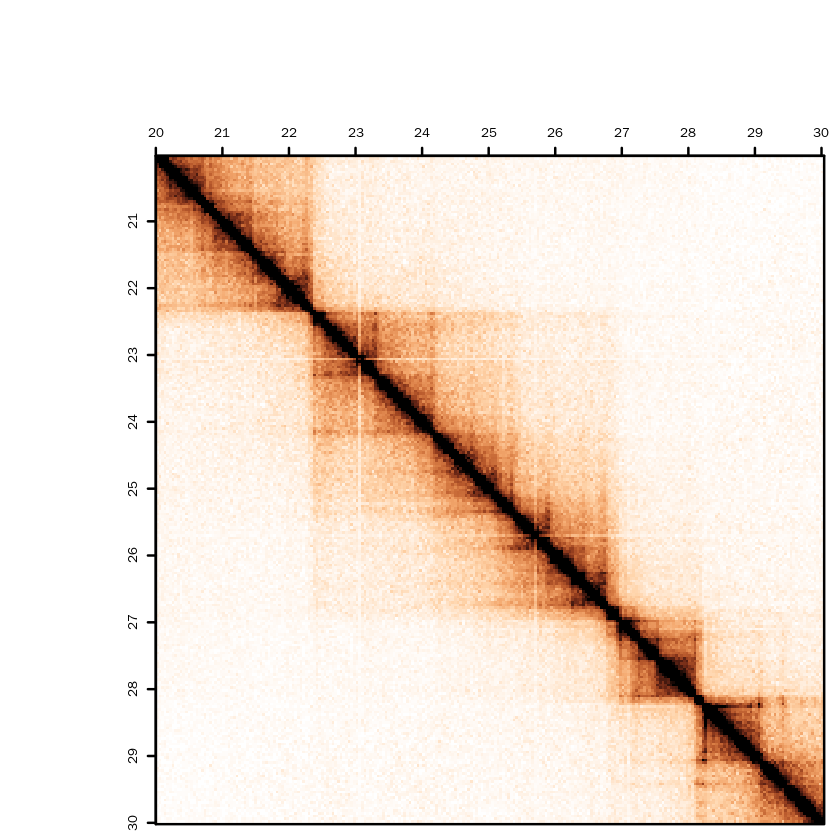

In [2]:
# test_exp <- get_test_data("40k", download = TRUE)
test_exp <- get_test_data("40k", download = FALSE)
hic_matrixplot(
  test_exp,
  chrom = "chr21", start = 20e6, end = 30e6,
  cut.off = 500
)

# Loading data

## Data structures of input

### experiment object (signal matrix + index file)
GENOVA expects two input files: 
- the signal
    - Signal-files have three columns (bin1, bin2, contactCount)
- and the index-file
    - index-files have four (chromosome, start, end, bin). These are the default output of the Hi-C mapping pipeline HiC-Pro, where they are called \*.matrix and \*.bed. The files are expected to be genome-wide and may be corrected with ICE-normalisation.

### experiment object 解析

#### HiC-Pro原始数据查看

通过计算所有样本的 iced 矩阵的原始 contacts 总数，判断 scale\_bp的参数选择

```
───────┬────────────────────────────────────────────────────────────────────────────────────────
       │ File: 293T_HiC_GFP_rep1_1000000_iced.matrix
───────┼────────────────────────────────────────────────────────────────────────────────────────
   1   │ 1   1   145997.140790
   2   │ 1   2   40009.942561
   3   │ 1   3   4778.191801

───────┬────────────────────────────────────────────────────────────────────────────────────────
       │ File: 293T_HiC_GFP_rep1_1000000_raw.matrix
───────┼────────────────────────────────────────────────────────────────────────────────────────
   1   │ 1   1   22253
   2   │ 1   2   16710
   3   │ 1   3   2018
   
───────┬────────────────────────────────────────────────────────────────────────────────────────
       │ File: 293T_HiC_GFP_rep1_1000000_raw_abs.bed
───────┼────────────────────────────────────────────────────────────────────────────────────────
   1   │ chr1    0   1000000 1
   2   │ chr1    1000000 2000000 2
   3   │ chr1    2000000 3000000 3
   
```

#### load\_contacts()函数解析
exp obj和由exp objs组成的 list 对象，是 GENOVA 进行分析的数据源，相当于  DataFrame、dataframe、tibble 等 之于 pandas、tidyverse等。
实例化一个 experiment-object（exp obj）也叫contacts-object的函数为load\_contacts()

一个exp-obj包含了一个样本在给定 resolution 下的 contacts、indices 和 atributes 信息。

```R
?load_contacts

# out
load_contacts(
  signal_path,        # Hi-C文件路径，可以是*.matrix (for HiCpro), *.cooler 或者 *.hic (for juicer)
  indices_path = NULL,# 默认为 NULL，仅有在用HiCPro 的*.matrix时需要一起指定，在此参数下指定对应的index文件路径，
                      #应该是一个 *.abs_bed文件
  resolution = 10000, # bins 分辨率，当使用*.hic(for juicer)作为输入时才需要指定，测试知道如果是 HiCPro 的文件则设置了也会被忽略
  sample_name = NULL, # 需要指定，样本名称，可视化时会展示
  centromeres = NULL, #（1）默认为 NULL，为 NULL 时程序会根据空的 bins 区间来预测centromeres 的所在位置；
                      #（2）如果有 centromeres 的信息，则需要指定一下，是一个 data.frame 对象，
                      #     as.data.frame(tibble)，如人的染色体 centromeres 信息，包含3列24行（1~22,X,Y,没有 M）
                      #     三列分别是 chromosome name, start-position, end-positions of centromeric regions.
                      #（3）设置为FALSE则不使用 centromere 信息也不进行推断
  colour = NULL,      # 设置样本可视化所用的颜色，样本间不能重合，但是同一样本不同分辨率可以保持一直
  z_norm = FALSE,     # 用z分数将每个染色体的矩阵归一化。
  scale_bp = 1e+09,   # Scale contacts to have genome-wide sum of 'scale_bp' reads (default: 1e9). 
                      # The amount of contacts in the ICE data.table is likely different from the input-data, 
                      # because it is scaled to a fixed number of reads
                      # (which can be set with the scale\_bp-option in `load_contacts()`).
                      # 最后理解了，就是把整个 sample 的 contacts 数量总和校正为 1e+09，也就是 1G
                      # 所以 ICED 矩阵导入之后的数值会发生变化
  scale_cis = FALSE,  # Only scale with cis-contacts.
  balancing = TRUE,   # TRUE (default) will perform matrix balancing for .cooler and KR for.hic. 
                      # 对 HiCPro 可以不设置这个参数（设置为 TRUE 或者 FALSE 都不改变载入结果）直接输入 ICED 校正后（且用scale_bp矫正过）的矩阵
  legacy = FALSE,     # 默认为 FALSE，测试数据时可以设置为 TRUE，只返回最小矩阵的测试数据，我一般不用
  verbose = TRUE      # 是否使用完整路径Hi-C文件路径。这可能是*.matrix(for HiCPro)， *.cooler，*.hic(juicer)【不知道，这个参数有点迷】
)
```

例如：

```R
matrix_GFP_rep1_1M <- load_contacts(
    signal_path = '../matrix/1000000/293T_HiC_GFP_rep1_1000000_iced.matrix',
    indices_path = '../matrix/1000000/293T_HiC_GFP_rep1_1000000_raw_abs.bed',
    sample_name = "GFP_rep1", 
    colour = "#0A070D",
    balancing = FALSE,
)

matrix_GFP_rep1_1M


# out
A GENOVA contacts object named 'GFP_rep1' at a resolution of 1 Mb.
Contains the following slots:
- MAT	:	Triplet format matrix containing 4197685 informative bins.
- IDX	:	3103 genomic indices in BED format.
- CHRS	:	A vector of 24 chromosome names.
- CENTROMERES:	Locations of 20 centromeres.

This object is assigned the colour '#0A070D'
0 bins are masked.
Some chromosomes have been removed.
The data have not been Z-score normalised.
The original data were loaded in as balanced data.
```

这里有几个信息需要注意，一个exp obj包含了几个子对象：
- MAT: 三列的data.frame，记录的 bins 之间的 contact 数量，输入文件如果是iced 就是矫正过的，raw 为原始的
- IDX: 整个基因组被切成了3103份儿，例如下表，可以看到，每个染色体从 0 号位置开始切到最后，IDX 计数从 1 开始
       注意看 X、Y、M 染色体，因为长度不够，单独分为一个 bin，则每个染色体最后一个 bin都是长度较小的，也会单
       独分一个 bin
- CHRS: 24 条染色体，加名字
- CENTROMERES: 每条染色体着丝粒所在区域的位置
另外要注意的就是，包括了 sample name、resolution、是否经过 Z-score 归一化，原始数据在载入时是否认为是经过校正的
```text
───────┬────────────────────────────────────────────────────────────────────────────────────────
       │ File: 293T_HiC_GFP_rep1_1000000_raw_abs.bed
───────┼────────────────────────────────────────────────────────────────────────────────────────
   1   │ chr1    0   1000000 1
   2   │ chr1    1000000 2000000 2
   3   │ chr1    2000000 3000000 3
...
3044   │ chrX    156000000   156040895   3044
3045   │ chrY    0   1000000 3045
...
3101   │ chrY    56000000    57000000    3101
3102   │ chrY    57000000    57227415    3102
3103   │ chrM    0   16569   3103
```

Note: 帮助文档中的 Note
Some reference genomes have very small "random" or "patch" chromosomes, which can have zero contacts mapped to it (at certain resolutions). 'load_contacts' checks this and omits these chromosomes in the resulting experiment-object. The RMCHROM-flag will also be set to TRUE: this will help other GENOVA-functions to deal better with this problem. There is a slight performance-cost during the construction of the object, however.
```

#### exp-obj解析
查看 MAT 信息
```R
df.test <- head(matrix_GFP_rep1_10k$MAT, 10000)
head(df.test)
tail(matrix_GFP_rep1_10k$MAT)
# out
A data.table: 6 × 3
V1		V2		V3
<int>	<int>	<dbl>
2		2		1080.37979
2		19		95.42026
2		93		22.82525
2		110		28.37811
2		341		22.31233
2		4856	21.78017


# out 
V1		V2		V3
<int>	<int>	<dbl>
308802	308803	157.4218484
308802	308838	0.1142441
308803	308803	424.5345976
308838	308838	274.8670483
308838	308839	92.6843505
308839	308839	293.0771861

```

V1 是 bin-1， V2 是 bin-2，V3 是 balance（T/F）后，以及z-norm（T/F）后的 contacts 数


```R
table(df.test$V1)
# out
   2    4    5    6    7    8    9   10   11   12   13   14   19   20   21   27 
 150  113  216  681  679  364  519  386  474  156  442  368 1911  734  340 1197 
  28   29   51   52   53   59   60 
 413  307  144   81   67  252    6 
```

从上表看到，貌似并不是bin-1、bin-2简单的双层 for 循环，而是经过了过滤，看下表就知道的确如此
```text
───────┬────────────────────────────────────────────────────────────
       │ File: 293T_HiC_DddA11.DdCBE_JAK2_rep1_10000_iced.matrix
───────┼────────────────────────────────────────────────────────────
   1   │ 5   7   46.168696
   2   │ 5   389 10.642376
   3   │ 5   4161    12.441445
   4   │ 5   21176   10.771792
```

```R
dim(matrix_GFP_rep1_10k$MAT)
dim(matrix_GFP_rep2_10k$MAT)
dim(matrix_GFP_rep3_10k$MAT)

# out
262771032  3
255963731  3
118001524  3

# wc -l 293T_HiC_GFP_rep1_10000_iced.matrix                                     
# 262771032 293T_HiC_GFP_rep1_10000_iced.matrix

# 所以是记录了 matrix 中的每行信息信息
```

但是注意到一个重要的点, 加载进来的 contact 是经过一定处理的，但是原始文档没有解释，后面搞清楚怎么回事,后来在文档中找到了说明

The amount of contacts in the ICE data.table is likely different from the input-data, 
because it is scaled to a fixed number of reads
(which can be set with the scale\_bp-option in `load_contacts()`).

```R
head(matrix_GFP_rep1_10k$MAT)

# out
A data.table: 6 × 3
V1		V2		V3
<int>	<int>	<dbl>
2		2		1080.37979
2		19		95.42026
2		93		22.82525

# ───────┬───────────────────────────────────────────────
#        │ File: 293T_HiC_GFP_rep1_10000_iced.matrix
# ───────┼───────────────────────────────────────────────
#    1   │ 2   2   662.011381
#    2   │ 2   19  58.469530
#    3   │ 2   93  13.986356
```

## Recommended resolutions 【重点】
To ensure computational strain and time is kept to a minimum, we recommend different resolutions for different functions (table1) 

More experienced users are free to deviate, while keeping in mind that these datasets are quite memory-heavy (table2) 

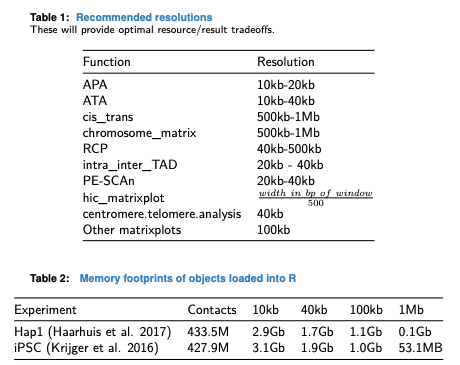

Several functions rely on centromere-information. You can add this in the form of a BED-like three-column data.frame when constructing the experiment-object ^[Please make sure that the chromosome-names match.]. If not present, the centromeres will be emperically identified by searching for the largest stretch of no coverage on a chromosome.

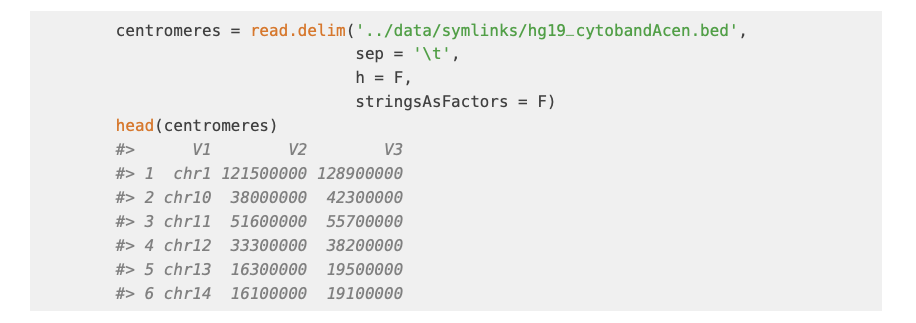

## Get centromere.bed

Get centromere.bed from UCSC GenomeBrowserGet centromere.bed from UCSC GenomeBrowser


> https://groups.google.com/a/soe.ucsc.edu/g/genome/c/c9eZ_fywMbo/m/2sgUU2QaAwAJ

You can get slightly different centromere coordinates than the centromeres track via the cytoBandIdeo table. 

- Similar to before, head to the Table Browser
- Choose the *Mapping and Sequencing* group
- Select the *ChromosomeBand (Ideogram)* track
- Then select filter, and enter "*cen*" in the *gieStain* field
- This leads to output like the following:

```
chr1 121700000 123400000 p11.1 acen
chr1 123400000 125100000 q11 acen
chr2 91800000 93900000 p11.1 acen
chr2 93900000 96000000 q11.1 acen
...
```

Here each chromosome will have two entries, and will overlap so you can merge them into a single entry. Unfortunately, these coordinates will differ from those in the centromeres track, even if you were to create single, per chromosome entries out of the centromeres track items. You may find this previously answered mailing list question helpful in deciding what data set to choose: https://groups.google.com/a/soe.ucsc.edu/d/msg/genome/SaR2y4UNrWg/XsGdMI3AazgJ

IF you have any further questions, please reply to gen...@soe.ucsc.edu. 

All messages sent to that address are archived on a publicly-accessible forum. If your question includes sensitive data, you may send it instead to genom...@soe.ucsc.edu.

Christopher Lee

UCSC Genomics Institute

On Thu, Jan 26, 2017 at 8:58 AM, Jeltje van Baren

In [3]:
# hg38 centromeres
centromeres_hg38_raw = read_tsv('program/ucsc_hg38_MappingAndSequencing_ChromosomeBandIdeogram_genome_filter_cen.bed',
                        col_names=c('chrom', 'start', 'stop', 'anno'))
centromeres_hg38 <- centromeres_hg38_raw %>% 
    select(chrom, start, stop) %>% 
    group_by(chrom) %>% 
    summarize(start=min(start), stop=max(stop))

# centromeres_hg38

centromeres <- centromeres_hg38
# head(centromeres)
centromeres

Rows: 48 Columns: 4
── Column specification ─────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, anno
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chrom,start,stop
<chr>,<dbl>,<dbl>
chr1,121700000,125100000
chr10,38000000,41600000
chr11,51000000,55800000
chr12,33200000,37800000
chr13,16500000,18900000
chr14,16100000,18200000
chr15,17500000,20500000
chr16,35300000,38400000
chr17,22700000,27400000


## Construct.experiment
Every Hi-C experiment will be stored in an experiment-object. 

This is done by invoking the `construct.experiment` function. 

Inside, several sanity checks will be performed, data is normalised to the total number of reads and scaled to a billion reads (the default value of the `BPscaling`-option). 

For this example, we are going to use the Hi-C maps of WT and $\Delta$WAPL Hap1 cells from Haarhuis et al. [-@Haarhuis2017]. Since the genome-wide analyses do not need very high-resolution data, we will construct both 10kb, 40kb and 1Mb resolution experiment-objects. 

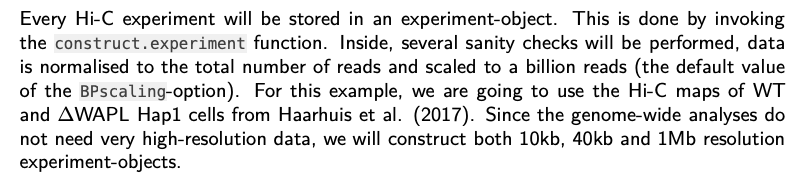

```{r CONSTRUCT, echo=T, warning=FALSE, error=F, results='hide', cache=F, cache.lazy=F}
Hap1_WT_10kb <- load_contacts(
  signal_path = '../data/symlinks/WT_10000_iced.matrix', 
  indices_path = '../data/symlinks/WT_10000_abs.bed',  
  sample_name = "WT", 
  colour = "black"
)
Hap1_WAPL_10kb <- load_contacts(
  signal_path = '../data/symlinks/WAPL_10000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_10000_abs.bed', 
  sample_name = "WAPL", 
  colour = "red"
)
Hap1_SCC4_10kb <- load_contacts(
  signal_path = '../data/symlinks/SCC4_10000_iced.matrix', 
  indices_path = '../data/symlinks/SCC4_10000_abs.bed', 
  sample_name = "SCC4", 
  colour = "green"
)
Hap1_WT_40kb <- load_contacts(
  signal_path = '../data/symlinks/WT_40000_iced.matrix', 
  indices_path = '../data/symlinks/WT_40000_abs.bed', 
  sample_name = "WT",  
  colour = "black"
)
Hap1_WAPL_40kb <- load_contacts(
  signal_path = '../data/symlinks/WAPL_40000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_40000_abs.bed', 
  sample_name = "WAPL", 
  colour = "red"
)
Hap1_WT_1MB <- load_contacts(
  signal_path = '../data/symlinks/WT_1000000_iced.matrix', 
  indices_path = '../data/symlinks/WT_1000000_abs.bed', 
  sample_name = "WT", centromeres = centromeres,
  colour = "black"
)
Hap1_WAPL_1MB <- load_contacts(
  signal_path = '../data/symlinks/WAPL_1000000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_1000000_abs.bed', 
  sample_name = "WAPL", 
  centromeres = centromeres,
  colour = "red"
)
```



The resulting `contacts`-object has several slots. `MAT` and `IDX` are the signal- and index-data.tables. We also have slots for the included chromosomes (`CHRS`) and the given centromers (`CENTROMERES`). 
```{r peekEXP1, collapse=F, results='markup', echo = F}
str(Hap1_WT_10kb, width = 60,   vec.len=0, strict.width = 'wrap')
```

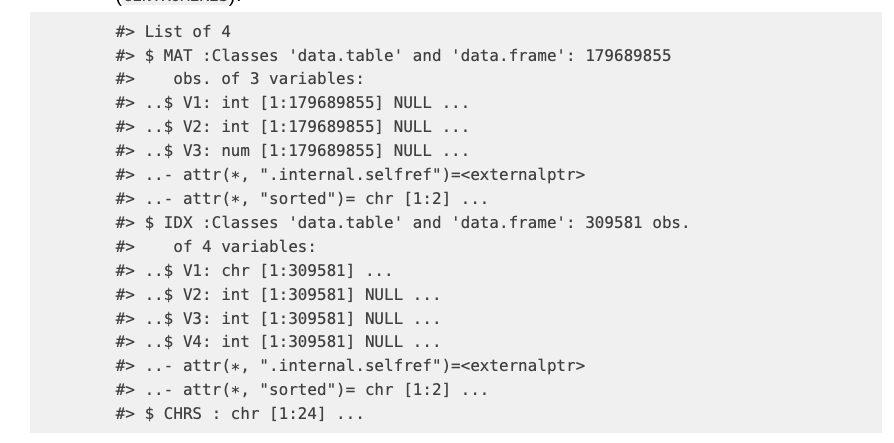

Finally, the object has a lot of specific attributes, like metadata and given parameters during loading. The amount of contacts in the *ICE* data.table is likely different from the input-data, because it is scaled to a fixed number of reads (which can be set with the `scale_bp`-option in `load_contacts()`).
```{r peekEXP2, collapse=F, results='markup', echo = F}
as.data.frame(
  attributes(Hap1_WT_10kb)
  [-1])
```


In [4]:
# 对于hic data，load的进度可能是7.4m / s
# 即 7.4G ~ 1000s ~ 16min30s
# 非常慢……


# 强烈建议将hic文件下载到本地，我是用M2 MacMini 16G的rosetta环境做了RData_back的转换，代码参考如下

### loading test data:

In [5]:
# matrix_test <- load_contacts(
#     signal_path = "../hic_file/SRR400264_00.rm_dup_pairs.allValidPairs.hic",
#     resolution = 100e3,
#     balancing = TRUE,
#     sample_name = "test",
#     colour = "black",
#     # centromeres = centromeres  # 下标出界
# )

In [6]:
# matrix_test <- load_contacts(
#     signal_path = "../hic_file/SRR400264_01.rm_dup_pairs.allValidPairs.hic",
#     resolution = 1000e3,
#     balancing = TRUE,
#     sample_name = "test",
#     colour = "black",
#     # centromeres = centromeres  # 下标出界
# )

In [7]:
# matrix_test <- load_contacts(
#     signal_path = "../hic_file/test.rm_dup_pairs.allValidPairs.hic",
#     resolution = 50e3,
#     balancing = TRUE,
#     sample_name = "test",
#     colour = "black",
#     # centromeres = centromeres  # 下标出界
# )

In [8]:
# matrix_test
# matrix_test$MAT
# matrix_test$IDX
# matrix_test$IDXCHRS
# matrix_test$CENTROMERES

In [9]:
# saveRDS(matrix_test, file = '../RData_back/matrix_test')
matrix_test <- readRDS(file = '../RData_back/matrix_test')
matrix_test

A GENOVA contacts object named 'test' at a resolution of 100 kb.
Contains the following slots:
- MAT	:	Triplet format matrix containing 1 informative bins.
- IDX	:	1 genomic indices in BED format.
- CHRS	:	A vector of 1 chromosome names.
- CENTROMERES:	No centromere information.
This object is assigned the colour 'black'
0 bins are masked.
No chromosomes have been removed.
The data have not been Z-score normalised.
The original data were loaded in as balanced data.

In [10]:
rm(matrix_test)

### loading treatment 1: GFP control

#### 10kb

In [11]:
# matrix_GFP_rep1_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     # centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [12]:
# matrix_GFP_rep2_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     # centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [13]:
# matrix_GFP_rep3_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 10e3, # 10 kb(e3) q
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [14]:
# saveRDS(matrix_GFP_rep1_10k, file = '../RData_back/matrix_GFP_rep1_10k')
# saveRDS(matrix_GFP_rep2_10k, file = '../RData_back/matrix_GFP_rep2_10k')
# saveRDS(matrix_GFP_rep3_10k, file = '../RData_back/matrix_GFP_rep3_10k')

matrix_GFP_rep1_10k <- readRDS(file = '../RData_back/matrix_GFP_rep1_10k')
matrix_GFP_rep2_10k <- readRDS(file = '../RData_back/matrix_GFP_rep2_10k')
matrix_GFP_rep3_10k <- readRDS(file = '../RData_back/matrix_GFP_rep3_10k')

#### 50kb

In [15]:
# matrix_GFP_rep1_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     # centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [16]:
# matrix_GFP_rep2_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [17]:
# matrix_GFP_rep3_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [18]:
# saveRDS(matrix_GFP_rep1_50k, file = '../RData_back/matrix_GFP_rep1_50k')
# saveRDS(matrix_GFP_rep2_50k, file = '../RData_back/matrix_GFP_rep2_50k')
# saveRDS(matrix_GFP_rep3_50k, file = '../RData_back/matrix_GFP_rep3_50k')

matrix_GFP_rep1_50k <- readRDS(file = '../RData_back/matrix_GFP_rep1_50k')
matrix_GFP_rep2_50k <- readRDS(file = '../RData_back/matrix_GFP_rep2_50k')
matrix_GFP_rep3_50k <- readRDS(file = '../RData_back/matrix_GFP_rep3_50k')

#### 100kb

In [19]:
# matrix_GFP_rep1_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     # centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [20]:
# matrix_GFP_rep2_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [21]:
# matrix_GFP_rep3_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [354]:
# saveRDS(matrix_GFP_rep1_100k, file = '../RData_back/matrix_GFP_rep1_100k')
# saveRDS(matrix_GFP_rep2_100k, file = '../RData_back/matrix_GFP_rep2_100k')
# saveRDS(matrix_GFP_rep3_100k, file = '../RData_back/matrix_GFP_rep3_100k')

matrix_GFP_rep1_100k <- readRDS(file = '../RData_back/matrix_GFP_rep1_100k')
matrix_GFP_rep2_100k <- readRDS(file = '../RData_back/matrix_GFP_rep2_100k')
matrix_GFP_rep3_100k <- readRDS(file = '../RData_back/matrix_GFP_rep3_100k')

#### 200kb

In [23]:
# matrix_GFP_rep1_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [24]:
# matrix_GFP_rep2_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [25]:
# matrix_GFP_rep3_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [26]:
# saveRDS(matrix_GFP_rep1_200k, file = '../RData_back/matrix_GFP_rep1_200k')
# saveRDS(matrix_GFP_rep2_200k, file = '../RData_back/matrix_GFP_rep2_200k')
# saveRDS(matrix_GFP_rep3_200k, file = '../RData_back/matrix_GFP_rep3_200k')

matrix_GFP_rep1_200k <- readRDS(file = '../RData_back/matrix_GFP_rep1_200k')
matrix_GFP_rep2_200k <- readRDS(file = '../RData_back/matrix_GFP_rep2_200k')
matrix_GFP_rep3_200k <- readRDS(file = '../RData_back/matrix_GFP_rep3_200k')

#### 500kb

In [27]:
# matrix_GFP_rep1_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [28]:
# matrix_GFP_rep2_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [29]:
# matrix_GFP_rep3_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [30]:
# saveRDS(matrix_GFP_rep1_500k, file = '../RData_back/matrix_GFP_rep1_500k')
# saveRDS(matrix_GFP_rep2_500k, file = '../RData_back/matrix_GFP_rep2_500k')
# saveRDS(matrix_GFP_rep3_500k, file = '../RData_back/matrix_GFP_rep3_500k')

matrix_GFP_rep1_500k <- readRDS(file = '../RData_back/matrix_GFP_rep1_500k')
matrix_GFP_rep2_500k <- readRDS(file = '../RData_back/matrix_GFP_rep2_500k')
matrix_GFP_rep3_500k <- readRDS(file = '../RData_back/matrix_GFP_rep3_500k')

#### 1M

In [31]:
# matrix_GFP_rep1_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep1",
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#0A070D",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [32]:
# matrix_GFP_rep2_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep2",
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#704F92",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [33]:
# matrix_GFP_rep3_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_GFP_rep3.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "GFP_rep3",
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B4502A",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [34]:
# saveRDS(matrix_GFP_rep1_1M, file = '../RData_back/matrix_GFP_rep1_1M')
# saveRDS(matrix_GFP_rep2_1M, file = '../RData_back/matrix_GFP_rep2_1M')
# saveRDS(matrix_GFP_rep3_1M, file = '../RData_back/matrix_GFP_rep3_1M')

matrix_GFP_rep1_1M <- readRDS(file = '../RData_back/matrix_GFP_rep1_1M')
matrix_GFP_rep2_1M <- readRDS(file = '../RData_back/matrix_GFP_rep2_1M')
matrix_GFP_rep3_1M <- readRDS(file = '../RData_back/matrix_GFP_rep3_1M')

### loading treatment 2: Nat22Fig4wt

#### 10kb

In [35]:
# 10kb
# matrix_Nat22Fig4wt_10k <- load_contacts(
#     signal_path = '../matrix/10000/293T_HiC_Nature2022.Fig4-WT_10000_iced.matrix',
#     indices_path = '../matrix/10000/293T_HiC_Nature2022.Fig4-WT_10000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [36]:
# saveRDS(matrix_Nat22Fig4wt_10k, file = '../RData_back/matrix_Nat22Fig4wt_10k')

# matrix_Nat22Fig4wt_10k <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_10k')

#### 50kb

In [37]:
# 50kb
# matrix_Nat22Fig4wt_50k <- load_contacts(
#     signal_path = '../matrix/50000/293T_HiC_Nature2022.Fig4-WT_50000_iced.matrix',
#     indices_path = '../matrix/50000/293T_HiC_Nature2022.Fig4-WT_50000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [38]:
# saveRDS(matrix_Nat22Fig4wt_50k, file = '../RData_back/matrix_Nat22Fig4wt_50k')

# matrix_Nat22Fig4wt_50k <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_50k')

#### 100kb

In [39]:
# 100kb
# matrix_Nat22Fig4wt_100k <- load_contacts(
#     signal_path = '../matrix/100000/293T_HiC_Nature2022.Fig4-WT_100000_iced.matrix',
#     indices_path = '../matrix/100000/293T_HiC_Nature2022.Fig4-WT_100000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [40]:
# saveRDS(matrix_Nat22Fig4wt_100k, file = '../RData_back/matrix_Nat22Fig4wt_100k')

# matrix_Nat22Fig4wt_100k <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_100k')

#### 200kb

In [41]:
# 200kb
# matrix_Nat22Fig4wt_200k <- load_contacts(
#     signal_path = '../matrix/200000/293T_HiC_Nature2022.Fig4-WT_200000_iced.matrix',
#     indices_path = '../matrix/200000/293T_HiC_Nature2022.Fig4-WT_200000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [42]:
# saveRDS(matrix_Nat22Fig4wt_200k, file = '../RData_back/matrix_Nat22Fig4wt_200k')

# matrix_Nat22Fig4wt_200k <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_200k')

#### 500kb

In [43]:
# 500kb
# matrix_Nat22Fig4wt_500k <- load_contacts(
#     signal_path = '../matrix/500000/293T_HiC_Nature2022.Fig4-WT_500000_iced.matrix',
#     indices_path = '../matrix/500000/293T_HiC_Nature2022.Fig4-WT_500000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [44]:
# saveRDS(matrix_Nat22Fig4wt_500k, file = '../RData_back/matrix_Nat22Fig4wt_500k')

# matrix_Nat22Fig4wt_500k <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_500k')

#### 1M

In [45]:
# 1M
# matrix_Nat22Fig4wt_1M <- load_contacts(
#     signal_path = '../matrix/1000000/293T_HiC_Nature2022.Fig4-WT_1000000_iced.matrix',
#     indices_path = '../matrix/1000000/293T_HiC_Nature2022.Fig4-WT_1000000_raw_abs.bed',
#     sample_name = "Nat22Fig4wt", 
#     colour = "#C1AFD4",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [46]:
# saveRDS(matrix_Nat22Fig4wt_1M, file = '../RData_back/matrix_Nat22Fig4wt_1M')

# matrix_Nat22Fig4wt_1M <- readRDS(file = '../RData_back/matrix_Nat22Fig4wt_1M')

### loading treatment 3: ND6-DddAwt-DdCBE

#### 10kb

In [47]:
# matrix_ND6_DddAwt_rep1_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [48]:
# saveRDS(matrix_ND6_DddAwt_rep1_10k, file = '../RData_back/matrix_ND6_DddAwt_rep1_10k')
# saveRDS(matrix_ND6_DddAwt_rep2_10k, file = '../RData_back/matrix_ND6_DddAwt_rep2_10k')
matrix_ND6_DddAwt_rep1_10k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_10k')
matrix_ND6_DddAwt_rep2_10k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_10k')

#### 50kb

In [49]:
# matrix_ND6_DddAwt_rep1_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [50]:
# saveRDS(matrix_ND6_DddAwt_rep1_50k, file = '../RData_back/matrix_ND6_DddAwt_rep1_50k')
# saveRDS(matrix_ND6_DddAwt_rep2_50k, file = '../RData_back/matrix_ND6_DddAwt_rep2_50k')
matrix_ND6_DddAwt_rep1_50k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_50k')
matrix_ND6_DddAwt_rep2_50k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_50k')

#### 100kb

In [51]:
# matrix_ND6_DddAwt_rep1_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [355]:
# saveRDS(matrix_ND6_DddAwt_rep1_100k, file = '../RData_back/matrix_ND6_DddAwt_rep1_100k')
# saveRDS(matrix_ND6_DddAwt_rep2_100k, file = '../RData_back/matrix_ND6_DddAwt_rep2_100k')
matrix_ND6_DddAwt_rep1_100k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_100k')
matrix_ND6_DddAwt_rep2_100k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_100k')

#### 200kb

In [53]:
# matrix_ND6_DddAwt_rep1_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [54]:
# saveRDS(matrix_ND6_DddAwt_rep1_200k, file = '../RData_back/matrix_ND6_DddAwt_rep1_200k')
# saveRDS(matrix_ND6_DddAwt_rep2_200k, file = '../RData_back/matrix_ND6_DddAwt_rep2_200k')
matrix_ND6_DddAwt_rep1_200k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_200k')
matrix_ND6_DddAwt_rep2_200k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_200k')

#### 500kb

In [55]:
# matrix_ND6_DddAwt_rep1_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [56]:
# saveRDS(matrix_ND6_DddAwt_rep1_500k, file = '../RData_back/matrix_ND6_DddAwt_rep1_500k')
# saveRDS(matrix_ND6_DddAwt_rep2_500k, file = '../RData_back/matrix_ND6_DddAwt_rep2_500k')
matrix_ND6_DddAwt_rep1_500k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_500k')
matrix_ND6_DddAwt_rep2_500k <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_500k')

#### 1M

In [57]:
# matrix_ND6_DddAwt_rep1_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep1",
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

# matrix_ND6_DddAwt_rep2_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddAwt.DdCBE_ND6_rep2.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "ND6-DddAwt_rep2",
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#219ebc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [58]:
# saveRDS(matrix_ND6_DddAwt_rep1_1M, file = '../RData_back/matrix_ND6_DddAwt_rep1_1M')
# saveRDS(matrix_ND6_DddAwt_rep2_1M, file = '../RData_back/matrix_ND6_DddAwt_rep2_1M')
matrix_ND6_DddAwt_rep1_1M <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep1_1M')
matrix_ND6_DddAwt_rep2_1M <- readRDS(file = '../RData_back/matrix_ND6_DddAwt_rep2_1M')

### loading treatment 4: SIRT6-DddA11-DdCBE

#### 10kb

In [59]:
# matrix_SIRT6_DddA11_rep1_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [60]:
# saveRDS(matrix_SIRT6_DddA11_rep1_10k, file = '../RData_back/matrix_SIRT6_DddA11_rep1_10k')
matrix_SIRT6_DddA11_rep1_10k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_10k')

#### 50kb

In [61]:
# matrix_SIRT6_DddA11_rep1_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [62]:
# saveRDS(matrix_SIRT6_DddA11_rep1_50k, file = '../RData_back/matrix_SIRT6_DddA11_rep1_50k')
matrix_SIRT6_DddA11_rep1_50k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_50k')

#### 100kb

In [63]:
# matrix_SIRT6_DddA11_rep1_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [64]:
# saveRDS(matrix_SIRT6_DddA11_rep1_100k, file = '../RData_back/matrix_SIRT6_DddA11_rep1_100k')
matrix_SIRT6_DddA11_rep1_100k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_100k')

#### 200kb

In [65]:
# matrix_SIRT6_DddA11_rep1_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [356]:
# saveRDS(matrix_SIRT6_DddA11_rep1_200k, file = '../RData_back/matrix_SIRT6_DddA11_rep1_200k')
matrix_SIRT6_DddA11_rep1_200k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_200k')

#### 500kb

In [67]:
# matrix_SIRT6_DddA11_rep1_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [68]:
# saveRDS(matrix_SIRT6_DddA11_rep1_500k, file = '../RData_back/matrix_SIRT6_DddA11_rep1_500k')
matrix_SIRT6_DddA11_rep1_500k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_500k')

#### 1M

In [69]:
# matrix_SIRT6_DddA11_rep1_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_rep1", 
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#cdb4db",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [70]:
# saveRDS(matrix_SIRT6_DddA11_rep1_1M, file = '../RData_back/matrix_SIRT6_DddA11_rep1_1M')
matrix_SIRT6_DddA11_rep1_1M <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_rep1_1M')

### loading treatment 5: JAK2-DddA11-DdCBE

#### 10kb

In [71]:
# matrix_JAK2_DddA11_rep1_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [72]:
# saveRDS(matrix_JAK2_DddA11_rep1_10k, file = '../RData_back/matrix_JAK2_DddA11_rep1_10k')
matrix_JAK2_DddA11_rep1_10k <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_10k')

#### 50kb

In [73]:
# matrix_JAK2_DddA11_rep1_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [74]:
# saveRDS(matrix_JAK2_DddA11_rep1_50k, file = '../RData_back/matrix_JAK2_DddA11_rep1_50k')
matrix_JAK2_DddA11_rep1_50k <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_50k')

#### 100kb

In [75]:
# matrix_JAK2_DddA11_rep1_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [76]:
# saveRDS(matrix_JAK2_DddA11_rep1_100k, file = '../RData_back/matrix_JAK2_DddA11_rep1_100k')
matrix_JAK2_DddA11_rep1_100k <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_100k')

#### 200kb

In [77]:
# matrix_JAK2_DddA11_rep1_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [357]:
# saveRDS(matrix_JAK2_DddA11_rep1_200k, file = '../RData_back/matrix_JAK2_DddA11_rep1_200k')
matrix_JAK2_DddA11_rep1_200k <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_200k')

#### 500kb

In [79]:
# matrix_JAK2_DddA11_rep1_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [80]:
# saveRDS(matrix_JAK2_DddA11_rep1_500k, file = '../RData_back/matrix_JAK2_DddA11_rep1_500k')
matrix_JAK2_DddA11_rep1_500k <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_500k')

#### 1M

In [81]:
# matrix_JAK2_DddA11_rep1_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.DdCBE_JAK2_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "JAK2-DddA11_rep1", 
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#ffafcc",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [82]:
# saveRDS(matrix_JAK2_DddA11_rep1_1M, file = '../RData_back/matrix_JAK2_DddA11_rep1_1M')
matrix_JAK2_DddA11_rep1_1M <- readRDS(file = '../RData_back/matrix_JAK2_DddA11_rep1_1M')

### loading treatment 6: SIRT6-DddA11.Dead-DdCBE

#### 10k

In [83]:
# matrix_SIRT6_DddA11_Dead_rep1_10k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 10e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [84]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_10k, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_10k')
matrix_SIRT6_DddA11_Dead_rep1_10k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_10k')

#### 50k

In [85]:
# matrix_SIRT6_DddA11_Dead_rep1_50k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 50e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [86]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_50k, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_50k')
matrix_SIRT6_DddA11_Dead_rep1_50k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_50k')

#### 100kb

In [87]:
# matrix_SIRT6_DddA11_Dead_rep1_100k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 100e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [89]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_100k, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_100k')
matrix_SIRT6_DddA11_Dead_rep1_100k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_100k')

#### 200kb

In [90]:
# matrix_SIRT6_DddA11_Dead_rep1_200k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 200e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [358]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_200k, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_200k')
matrix_SIRT6_DddA11_Dead_rep1_200k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_200k')

#### 500kb

In [92]:
# matrix_SIRT6_DddA11_Dead_rep1_500k <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 500e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [93]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_500k, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_500k')
matrix_SIRT6_DddA11_Dead_rep1_500k <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_500k')

#### 1M

In [94]:
# matrix_SIRT6_DddA11_Dead_rep1_1M <- load_contacts(
#     signal_path = '../hic_file/293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1.rm_dup_pairs.allValidPairs.hic',
#     sample_name = "SIRT6-DddA11_Dead_rep1", 
#     resolution = 1000e3, # 10 kb(e3) 
#     balancing = TRUE,
#     colour = "#B80006",
#     centromeres  = centromeres,
#     # scale_bp = 0.1e+09,
#     # z_norm = TRUE,
# )

In [95]:
# saveRDS(matrix_SIRT6_DddA11_Dead_rep1_1M, file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_1M')
matrix_SIRT6_DddA11_Dead_rep1_1M <- readRDS(file = '../RData_back/matrix_SIRT6_DddA11_Dead_rep1_1M')

### loading public data: auxin2days / washoff2days / untreated

In [96]:
# # 10kb
# mESC_auxin_2days_rep1_10kb <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_auxin-2days_rep1_10000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_auxin-2days_rep1_10000_raw_abs.bed',
#     sample_name = "auxin-2days_rep1", 
#     colour = "#f4acb7"
# )
# mESC_auxin_2days_rep2_10kb <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_auxin-2days_rep2_10000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_auxin-2days_rep2_10000_raw_abs.bed',
#     sample_name = "auxin-2days_rep2", 
#     colour = "#ffcad4"
# )
# # 50kb
# mESC_auxin_2days_rep1_50kb <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_auxin-2days_rep1_50000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_auxin-2days_rep1_50000_raw_abs.bed',
#     sample_name = "auxin-2days_rep1", 
#     colour = "#f4acb7"
# )
# mESC_auxin_2days_rep2_50kb <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_auxin-2days_rep2_50000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_auxin-2days_rep2_50000_raw_abs.bed',
#     sample_name = "auxin-2days_rep2", 
#     colour = "#ffcad4"
# )
# # 1M
# mESC_auxin_2days_rep1_1M <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_auxin-2days_rep1_1000000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_auxin-2days_rep1_1000000_raw_abs.bed',
#     sample_name = "auxin-2days_rep1", 
#     colour = "#f4acb7"
# )
# mESC_auxin_2days_rep2_1M <- load_contacts(
#     signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_auxin-2days_rep2_1000000_iced.matrix',
#     indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_auxin-2days_rep2_1000000_raw_abs.bed',
#     sample_name = "auxin-2days_rep2", 
#     colour = "#ffcad4"
# )

In [97]:
# # 10kb
# mESC_washoff_2days_rep1_10kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_washoff-2days_rep1_10000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_washoff-2days_rep1_10000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep1", 
#                               colour = "#a5a58d")
# mESC_washoff_2days_rep2_10kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_washoff-2days_rep2_10000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_washoff-2days_rep2_10000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep2", 
#                               colour = "#b7b7a4")
# # 50kb
# mESC_washoff_2days_rep1_50kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_washoff-2days_rep1_50000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_washoff-2days_rep1_50000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep1", 
#                               colour = "#a5a58d")
# mESC_washoff_2days_rep2_50kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_washoff-2days_rep2_50000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_washoff-2days_rep2_50000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep2", 
#                               colour = "#b7b7a4")
# # 1M
# mESC_washoff_2days_rep1_1M <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_washoff-2days_rep1_1000000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_washoff-2days_rep1_1000000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep1", 
#                               colour = "#a5a58d")
# mESC_washoff_2days_rep2_1M <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_washoff-2days_rep2_1000000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_washoff-2days_rep2_1000000_raw_abs.bed',
#                               sample_name = "washoff-2days_rep2", 
#                               colour = "#b7b7a4")

In [98]:
# # 10kb
# mESC_untreated_rep1_10kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_untreated_rep1_10000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_untreated_rep1_10000_raw_abs.bed',
#                               sample_name = "untreated_rep1", 
#                               colour = "#3D0002")
# mESC_untreated_rep2_10kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_untreated_rep2_10000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/10000/Hi-C_untreated_rep2_10000_raw_abs.bed',
#                               sample_name = "untreated_rep2", 
#                               colour = "#660003")
# # 50kb
# mESC_untreated_rep1_50kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_untreated_rep1_50000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_untreated_rep1_50000_raw_abs.bed',
#                               sample_name = "untreated_rep1", 
#                               colour = "#3D0002")
# mESC_untreated_rep2_50kb <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_untreated_rep2_50000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/50000/Hi-C_untreated_rep2_50000_raw_abs.bed',
#                               sample_name = "untreated_rep2", 
#                               colour = "#660003")
# # 1M
# mESC_untreated_rep1_1M <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_untreated_rep1_1000000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_untreated_rep1_1000000_raw_abs.bed',
#                               sample_name = "untreated_rep1", 
#                               colour = "#3D0002")
# mESC_untreated_rep2_1M <- load_contacts(signal_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_untreated_rep2_1000000_iced.matrix',
#                               indices_path = '/lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2022_DdCBE-3D-Genome_topic/2022-07-17_Repeat_2017_CELL_CTCF/HiC/matrix/1000000/Hi-C_untreated_rep2_1000000_raw_abs.bed',
#                               sample_name = "untreated_rep2", 
#                               colour = "#660003")

## Juicebox & cooler
Both `.hic` and `.cooler` files can be loaded from version 1 onwards. The same `load_contacts()` function can be used, which will automatically determine the file-type based on the extention. 

```{r J2G, eval=FALSE, highlight=FALSE}
Hap1_WT_10kb_juicer <- load_contacts(signal_path = '../data/symlinks/WT.hic', 
                                     sample_name = "WT", 
                                     resolution = 10e3, 
                                     balancing = TRUE,
			                               colour = "black")
Hap1_WT_10kb_cooler <- load_contacts(signal_path = '../data/symlinks/WT.cooler', 
                                     sample_name = "WT", 
                                     balancing = T,
			                               colour = "black")
```


# Genome-wide analyses
A good place to start your analyses are some functions on a genome-wide level. We can assess the quality of the library, identify translocations and generate contact probability (aka scaling or interaction decay plots).

- 一般从全基因组水平开始分析一个 Hi-C 数据，可以做的事情如：
    - 评估文库质量
    - 识别易位并生成接触概率`contact probability`
        - （又称缩放图或相互作用衰减图`aka scaling or interaction decay plots`）识别易位并生成接触概率`contact probability`（又称缩放图或相互作用衰减图`aka scaling or interaction decay plots`）

## *Cis*-quantification

<!-- Work by the group of Amos Tanay showed that the expected amount of intra-chromosomal contacts is the range of 90 to 93 percent [@Olivares-Chauvet2016]. Assuming that any extra inter-chromosomal contacts are due to debris/noise, the user might aspire to get the *cis*-percentages as close to 90% as possible. To compute the percentage of per-sample *cis*-contacts, we simply provide `cis_trans()` with the contacts-object of interest. The output can be used to make a barplot of the percentages *cis* per sample (figure 2). Work by the group of Amos Tanay showed that the expected amount of intra-chromosomal contacts is the range of 90 to 93 percent [@Olivares-Chauvet2016]. Assuming that any extra inter-chromosomal contacts are due to debris/noise, the user might aspire to get the *cis*-percentages as close to 90% as possible. To compute the percentage of per-sample *cis*-contacts, we simply provide `cis_trans()` with the contacts-object of interest. The output can be used to make a barplot of the percentages *cis* per sample (figure 2). 

Amos Tanay小组的工作表明，染色体内接触的预期数量在90%到93%之间[@Olivares-Chauvet2016]。假设任何额外的染色体间接触是由于碎片/噪音造成的，用户可能希望顺式百分比尽可能地接近90%。为了计算每个样本顺式接触的百分比，我们只需将感兴趣的接触对象提供给cis_trans()。输出结果可用于制作每个样本顺式百分比的柱状图（图2）。 -->

- 全基因组水平


```R
cisChrom_out <- cis_trans( list(Hap1_WT_1MB, Hap1_WAPL_1MB) )
barplot(cisChrom_out$cis, names.arg = cisChrom_out$sample, ylim = c(0, 100) )
abline(h = cisChrom_out$cis[1], col = 'red', lty = 3)
abline(h = cisChrom_out$cis[2], col = 'red', lty = 3)
```

<!-- 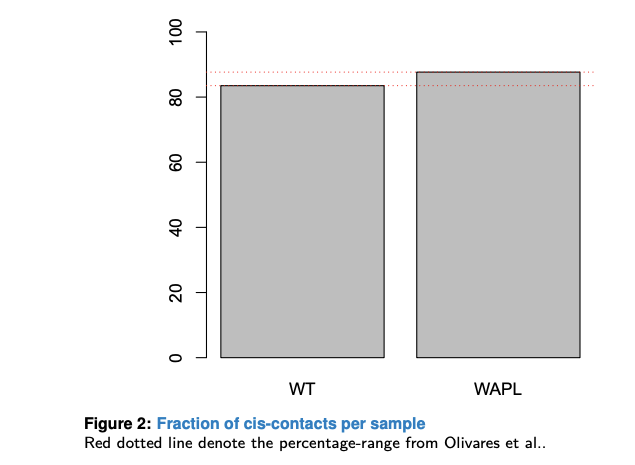 -->

<!-- ![](https://p.ipic.vip/wllmag.png) -->



<!-- The same function can also be ran on specific regions. For this example, we will compute the intra-arm percentages. Plotting this shows us that there are interesting differences between the amounts of intra-arm contacts in *cis*, which is can be attributed to the loss of TADs [@Haarhuis2017] (figure 3). 

**同样的功能也可以在特定区域运行同样的功能也可以在特定区域运行**。在这个例子中，我们将计算出臂内的百分比。绘图显示我们在顺式的臂内接触量之间存在有趣的差异，这可以归因于TADs的损失[@Haarhuis2017]（图3）。
 -->


- 局部水平

```R
p_arms <- data.frame('chromosome' = centromeres[,1],
                     'start' = 0,
                     'end' = centromeres[,2])
cisChrom_out <- cis_trans( list(Hap1_WT_10kb, Hap1_SCC4_10kb) , bed = p_arms)
barplot(cisChrom_out$cis, names.arg = cisChrom_out$sample, ylim = c(0, 100))
abline(h = 90, col = 'red', lty = 3)
abline(h = 93, col = 'red', lty = 3)
```

<!-- 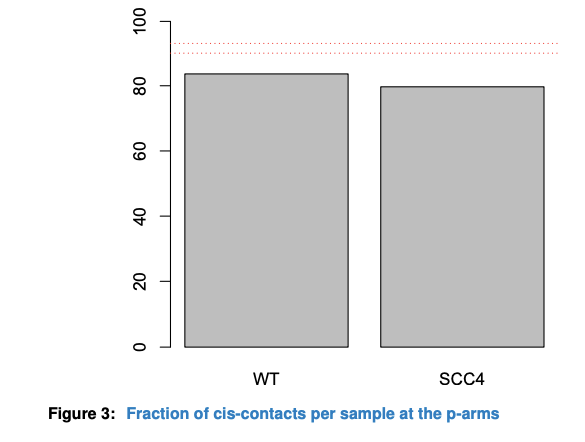 -->

<!-- ![](https://p.ipic.vip/21cd3l.png) -->









In [99]:
dir.create("../genova_plots", recursive=TRUE)

Warning message in dir.create("../genova_plots", recursive = TRUE):
“'../genova_plots'已存在”


### Genome wide

In [100]:
# 全基因组水平分析
samples_1M <- list(
    matrix_GFP_rep1_1M,
    matrix_GFP_rep2_1M,
    matrix_GFP_rep3_1M, 
    matrix_SIRT6_DddA11_Dead_rep1_1M, 
    matrix_ND6_DddAwt_rep1_1M,
    matrix_ND6_DddAwt_rep2_1M,
    matrix_JAK2_DddA11_rep1_1M,
    matrix_SIRT6_DddA11_rep1_1M
)
cisChrom_out <- cis_trans(samples_1M)

cisChrom_out

sample,cis,region
<chr>,<dbl>,<chr>
GFP_rep1,80.70025,genome-wide
GFP_rep2,78.24937,genome-wide
GFP_rep3,64.12013,genome-wide
SIRT6-DddA11_Dead_rep1,60.52776,genome-wide
ND6-DddAwt_rep1,75.66252,genome-wide
ND6-DddAwt_rep2,76.22336,genome-wide
JAK2-DddA11_rep1,62.95242,genome-wide
SIRT6-DddA11_rep1,66.41488,genome-wide


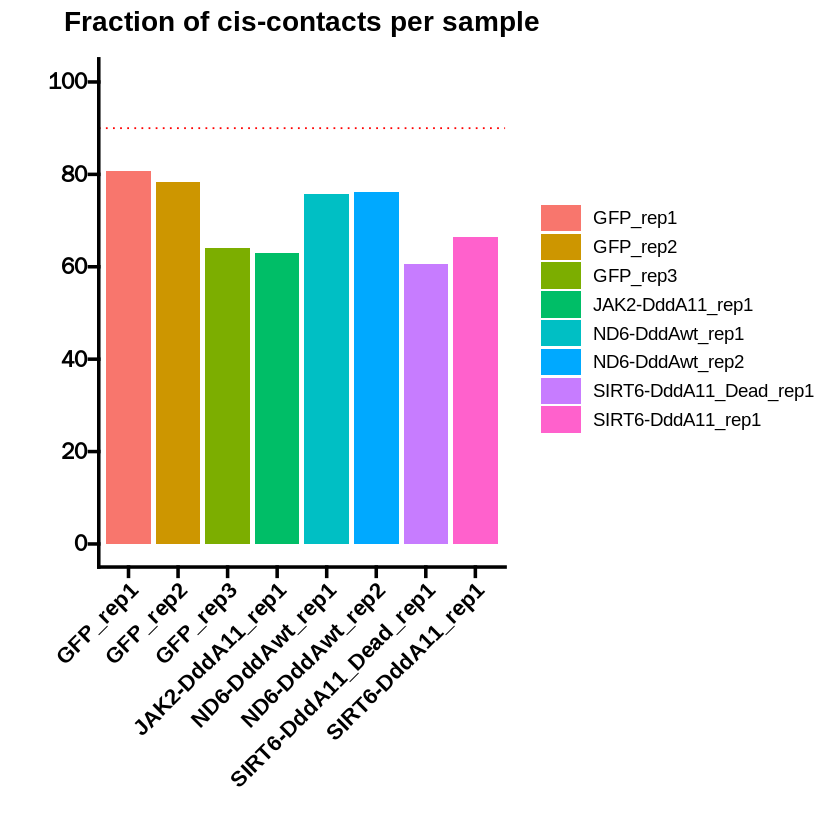

In [101]:
g1 <- ggplot() + 
    geom_bar(
        data = cisChrom_out,
        mapping=aes(x=sample, y=cis, fill=sample),
        stat="identity",
    ) +
    scale_y_continuous(
        limits = c(0, 100), 
        breaks = seq(0, 100, by=20),
    ) +
    geom_hline(yintercept=90, colour = 'red', lty = 3) +
    ggtitle("Fraction of cis-contacts per sample") + 
    xlab('') +
    ylab('') +
    theme_prism(base_size = 14, axis_text_angle=45)
g1

#这里报 warning remove rows，大概率是 load sample的时候 sample name弄错了（起重名了）

In [102]:
ggsave('../genova_plots/01_Cis-quantification_1M.pdf', g1)

Saving 6.67 x 6.67 in image


### Specific regions
For example, we will compute the intra-arm percentages

例如，我们将计算臂内百分比

In [103]:
p_arms <- centromeres
p_arms$start <- 0
p_arms

chrom,start,stop
<chr>,<dbl>,<dbl>
chr1,0,125100000
chr10,0,41600000
chr11,0,55800000
chr12,0,37800000
chr13,0,18900000
chr14,0,18200000
chr15,0,20500000
chr16,0,38400000
chr17,0,27400000


In [105]:
# # 局部水平分析 【非常耗时 ~3 min】
# samples_10k <- list(
#     matrix_GFP_rep1_10k,
#     matrix_GFP_rep2_10k,
#     matrix_GFP_rep3_10k, 
#     matrix_SIRT6_DddA11_Dead_rep1_10k,
#     matrix_ND6_DddAwt_rep1_10k,
#     matrix_ND6_DddAwt_rep2_10k,
#     matrix_JAK2_DddA11_rep1_10k,
#     matrix_SIRT6_DddA11_rep1_10k
# )
# cisChrom_out <- cis_trans(samples_10k, bed = p_arms)

# cisChrom_out

In [106]:
# g2 <- ggplot() + 
#     geom_bar(
#         data = cisChrom_out,
#         mapping=aes(x=sample, y=cis, fill=sample),
#         stat="identity",
#     ) +
#     scale_y_continuous(
#         limits = c(0, 100), 
#         breaks = seq(0, 100, by=20),
#     ) +
#     geom_hline(yintercept=90, colour = 'red', lty = 3) +
#     ggtitle("Fraction of cis-contacts \nper sample at the p-arms") + 
#     xlab('') +
#     ylab('') +
#     theme_prism(base_size = 14, axis_text_angle=45)
# g2

In [107]:
# ggsave('../genova_plots/02_Cis-quantification_10k.pdf', g2)

## Chromosome plots
<!-- Hi-C has been shown to be a powerful data-source to detect chromosomal rearrangements [@Harewood2017]. To find possible translocations, we can plot the genome-wide enrichment of interactions between all combinations of chromosomes. The values in the matrix are $log_2(observed/expected)$. The Hap1 cell line has two known translocations, which we can easily see in the resulting plot (figure \@ref(fig:chromMat1)). To narrow-in on this location, you could use the `trans.compartment.plot`-function (discussed below).

- Hi-C已被证明是检测染色体重排的强大数据源[@Harewood2017]。为了找到可能的易位，我们可以绘制全基因组范围内所有染色体组合之间相互作用的富集程度。矩阵中的值是$log_2(观察/预期)$。
- Hap1细胞系有两个已知的易位，我们可以很容易地在结果图中看到（图/@ref(fig:chromMat1)）。
- 为了缩小这个位置，你可以使用`trans.compartment.plot`-函数（在下面讨论）。 -->

- 能够查看染色体重排（易位等）

```R
# An automatic attempt is made to exclude the Y-chromosome and 
# mitochondrial genome
# Inversely, you can change the `include_chr` argument to select specific
# chromosomes
chr_mat <- chromosome_matrix(Hap1_WAPL_1MB)
visualise(chr_mat)
```

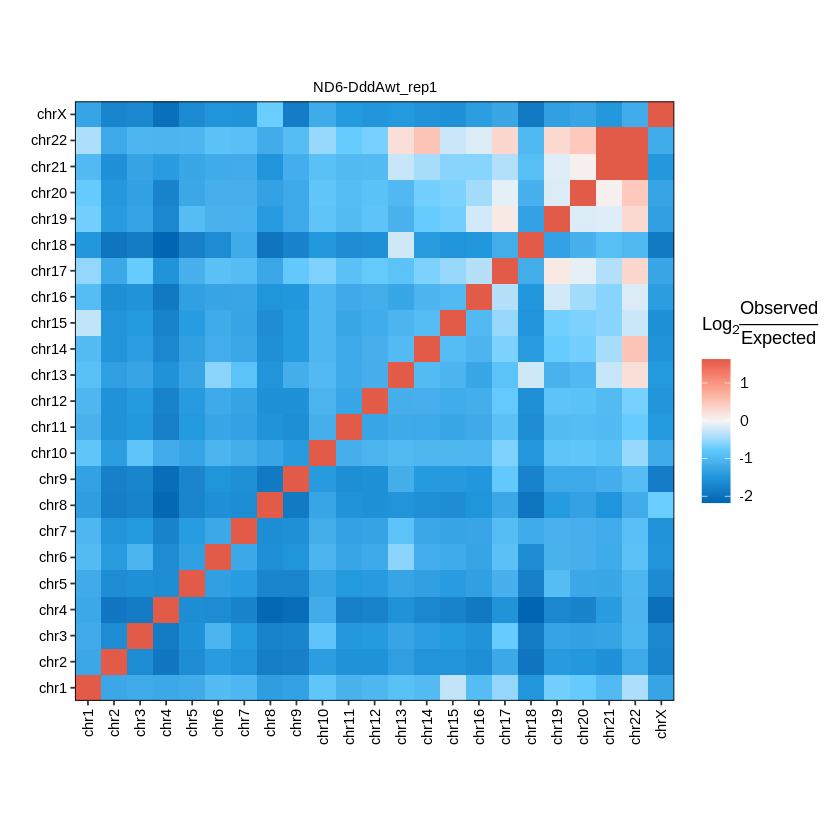

In [108]:
# chr_mat <- chromosome_matrix(matrix_GFP_rep3_1M, exclude_chr=c('chrM', 'chrY'))
# visualise(chr_mat)

# chr_mat <- chromosome_matrix(matrix_SIRT6_DddA11_rep1_1M, exclude_chr=c('chrM', 'chrY'))
# visualise(chr_mat)

# chr_mat <- chromosome_matrix(matrix_JAK2_DddA11_rep1_1M, exclude_chr=c('chrM', 'chrY'))
# visualise(chr_mat)

chr_mat <- chromosome_matrix(matrix_ND6_DddAwt_rep1_1M, exclude_chr=c('chrM', 'chrY'))
visualise(chr_mat)

In [112]:
samples_1M <- list(
    matrix_GFP_rep1_1M,
    matrix_GFP_rep2_1M,
    matrix_GFP_rep3_1M, 
    # matrix_SIRT6_DddA11_Dead_rep1_1M, 
    matrix_ND6_DddAwt_rep1_1M,
    matrix_ND6_DddAwt_rep2_1M,
    matrix_JAK2_DddA11_rep1_1M,
    matrix_SIRT6_DddA11_rep1_1M
)


# 一排放不下，拆一下
chr_mats1 <- chromosome_matrix(
    samples_1M[1:3], 
    expected = "trans",
    exclude_chr=c('chrM', 'chrY'), 
    sort_chr=TRUE
)
chr_mats2 <- chromosome_matrix(
    samples_1M[4:6], 
    expected = "trans",
    exclude_chr=c('chrM', 'chrY'), 
    sort_chr=TRUE
)
chr_mats3 <- chromosome_matrix(
    # samples_1M[7:8], 
    samples_1M[7], 
    expected = "trans",
    exclude_chr=c('chrM', 'chrY'), 
    sort_chr=TRUE
)
g1 <- visualise(chr_mats1)
g2 <- visualise(chr_mats2)
g3 <- visualise(chr_mats3)

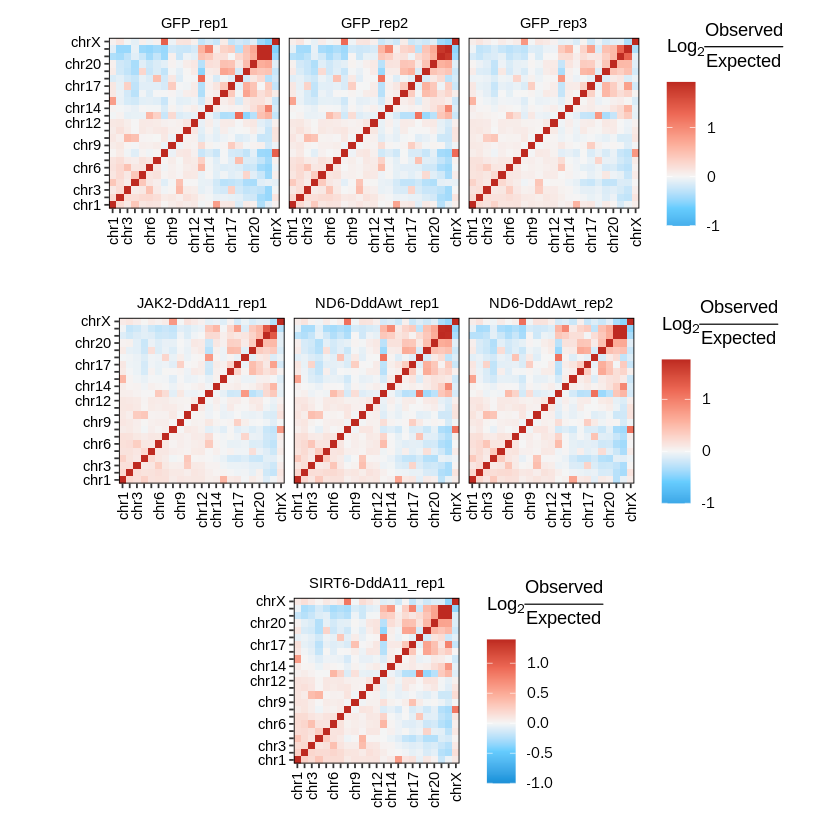

In [113]:
g <- plot_grid(
    g1, g2, g3,
    # labels=c("A", "B"), 
    ncol = 1
)
g

In [116]:
ggsave('../genova_plots/03_Chromosome_plots_expacted-trans_1M.pdf', g, width=14, height=10)

In [117]:
# 大致是根据Genome level的 trans contact 
# 再去查看细致的 contact，就需要用到trans.compartment.plot
# 例如
# Plot a trans-compartment plot of the q-arms of chromosome 13 and 18
# 看起来 HEK293T 细胞

# Draw interchromosomal interaction heatmap 
# for a chromosome (arm) with corresponding (cis) compartment scores
# trans.compartment.plot(
#     exp = matrix_GFP_rep1_50k,
#     chrom1 = 'chr13', arm1 = 'q', 
#     chrom2 = 'chr18', arm2 = 'q', 
#     cut.off = 10
#     # chip = H3K27ac_peaks
# )

## RCP (Relative Contact Probability)

### RCP解析
The Relative Contact Probability (RCP) computes the contact probability as a function of genomic distance, as described in (Lieberman-Aiden and Berkum 2009). This can be computed for a specific set of chromosomes or genome-wide. To ignore centromeric contacts (which have a aberrant RCP), centromeric information is needed. This is taken from the experiment-object or found empirically by comparing trans-interactions.

相对接触概率（RCP）计算接触概率作为基因组距离的函数，如（Lieberman-Aiden and Berkum 2009）中所述。这可以针对一组特定的染色体或全基因组进行计算。为了忽略中心体的接触（其RCP异常），需要中心体的信息。这是从实验对象中获取的，或通过比较反式反应凭经验找到的。

```R
RCP_out <- RCP(explist = list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
               chromsToUse = 'chr1')
```

The user can decide to plot the RCP per chromosome. If the data is sparse, a LOESS-smooting could be convenient. It takes the color and name from the experiment-objects. If we look at the resulting plot, we can see that the ∆W AP L has more interactions in the [±800kb, ±2Mb] range (figure 4). The sizes of TADs are fall into this range, so a next step could be to dive into the TAD-specific analyses (discussed below). Moreover, the ∆W AP L has less interactions in the far-cis range ([±10Mb, ±100Mb]): A- and B-compartments are often this size, so a next step could be to look more into compartmentalisation with compartment_matrixplot or trans.compartment.plot, for example.

用户可以决定绘制每个染色体的RCP。如果数据很稀疏，用LOESS平滑法可能比较方便。它从实验对象中获取颜色和名称。如果我们看一下结果图，我们可以看到，∆W AP L在[±800kb, ±2Mb]范围内有更多的相互作用（图4）。TADs的大小都属于这个范围，所以下一步可以深入到TAD的具体分析中去（下面讨论）。此外，∆W AP L在远顺式范围内（[±10Mb, ±100Mb]）的相互作用较少。A-和B-区块通常是这个大小，所以下一步可以用compartment_matrixplot或trans.compartment.plot等方法进一步研究区块化。

```R
visualise(RCP_out)
```



```R
?RCP
# out

- Produce a dataframe with the probabilities of contacts in a set of distance-bins. 
- Bins are created on a log scale, which leads to equal amounts of datapoints per bin.
- 生成一个 dataframe，包含一组 distance-bins 的 contacts 接触概率（probabilities of contacts）。
- bins 使用 log scale 进行计算，这能够保证每个bins有等量的数据点。【没动为啥等量】


# 用法
RCP(
  explist,             # 一组 exp-obj
  bedlist = NULL,      # A named list of BED-like dataframes of the regions of interest.
  chromsToUse = NULL,  # A vector containing the chromosome-names of interest.
  maxDistance = NULL,  # The maximal distance to calculate RCPs for.
  genomeWide = NULL    # Normalise with genome-wide counts or per-chromosome (default).
)


# 返回值
一个RCP_discovery对象，包括:
- raw: a per-distance probability
- smooth: a log10-mean smoothed probability

# 推荐分辨率
40kb-500kb

# 举例
# ---------->
# Calculate the RCP of chromosome 1
RCP_out = RCP(experimentList = list('WT' = WT_1MB), chromsToUse = 'chr1')
# Plot the RCP
visualise(RCP_out)
# ---------->
```
---

注意！！！

```text
    # chromsToUse 和 bedlist 是冲突的，只能二选一！
    # 其实很合理，因为统计的 region 只能指定要么是 chromosome 尺度，要么是 region list 尺度的，不能是
    # 某 chromosome 上的 sub region list 尺度！
```

如图所示:

chromsToUse 和 bedlist 是冲突的，只能二选一,但是指定后不会报错，bedlist 优先级更高！

![](https://p.ipic.vip/fkupip.png)


---

### RCP 计算

#### Genome wide

In [165]:
samples_50k <- list(
    matrix_GFP_rep1_50k,
    matrix_GFP_rep2_50k,
    matrix_GFP_rep3_50k, 
    matrix_SIRT6_DddA11_Dead_rep1_50k,
    matrix_ND6_DddAwt_rep1_50k,
    matrix_ND6_DddAwt_rep2_50k,
    matrix_JAK2_DddA11_rep1_50k,
    matrix_SIRT6_DddA11_rep1_50k
)

In [166]:
RCP_out <- RCP(
    explist = samples_50k,
    genomeWide = TRUE
)

head(RCP_out$raw, 4)
head(RCP_out$smooth, 4)

region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
genome-wide,0,0.1813363,GFP_rep1,#0A070D
genome-wide,0,0.1725810,GFP_rep2,#704F92
genome-wide,0,0.1279199,GFP_rep3,#B4502A
genome-wide,0,0.1129469,SIRT6-DddA11_Dead_rep1,#B80006


region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
genome-wide,0,0.18133626,GFP_rep1,#0A070D
genome-wide,50000,0.11589549,GFP_rep1,#0A070D
genome-wide,100000,0.05519976,GFP_rep1,#0A070D
genome-wide,150000,0.04011491,GFP_rep1,#0A070D


In [179]:
RCP_out$raw[RCP_out$raw$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'

RCP_out$smooth[RCP_out$smooth$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
# RCP_out$raw
# RCP_out$smooth

region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
genome-wide,0,0.18133626,GFP_rep1,#0A070D
genome-wide,0,0.17258099,GFP_rep2,#704F92
genome-wide,0,0.12791985,GFP_rep3,#B4502A
genome-wide,0,0.11294690,SIRT6-DddA11_Dead_rep1,#B80006
genome-wide,0,0.17847539,ND6-DddAwt_rep1,#219ebc
genome-wide,0,0.18345958,ND6-DddAwt_rep2,#220ebd
genome-wide,0,0.13341799,JAK2-DddA11_rep1,#ffafcc
genome-wide,0,0.13459579,SIRT6-DddA11_rep1,#cdb4db
genome-wide,50000,0.11589549,GFP_rep1,#0A070D


region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
genome-wide,0,0.181336257,GFP_rep1,#0A070D
genome-wide,50000,0.115895491,GFP_rep1,#0A070D
genome-wide,100000,0.055199762,GFP_rep1,#0A070D
genome-wide,150000,0.040114906,GFP_rep1,#0A070D
genome-wide,200000,0.032191623,GFP_rep1,#0A070D
genome-wide,250000,0.027004248,GFP_rep1,#0A070D
genome-wide,300000,0.023264260,GFP_rep1,#0A070D
genome-wide,350000,0.020358933,GFP_rep1,#0A070D
genome-wide,400000,0.018037133,GFP_rep1,#0A070D


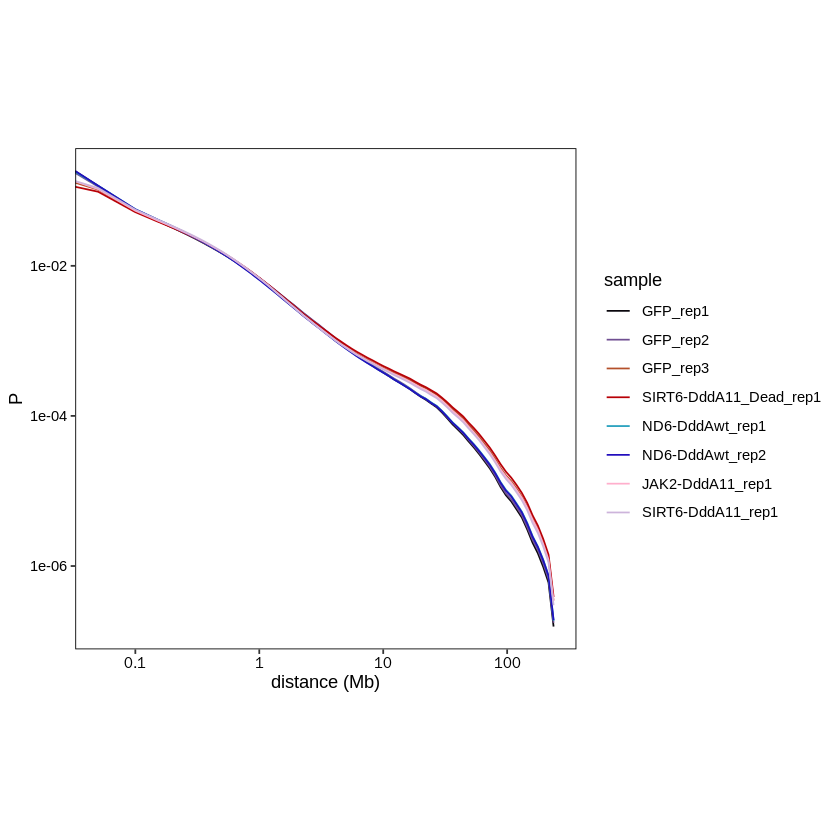

In [180]:
visualise(RCP_out)

In [181]:
# DEBUG
RCP_out$raw %>% group_by(samplename, colour) %>% summarise(sample=n())

`summarise()` has grouped output by 'samplename'. You can override using the `.groups` argument.


samplename,colour,sample
<fct>,<chr>,<int>
GFP_rep1,#0A070D,4948
GFP_rep2,#704F92,4948
GFP_rep3,#B4502A,4940
SIRT6-DddA11_Dead_rep1,#B80006,4955
ND6-DddAwt_rep1,#219ebc,4957
ND6-DddAwt_rep2,#220ebd,4946
JAK2-DddA11_rep1,#ffafcc,4931
SIRT6-DddA11_rep1,#cdb4db,4947


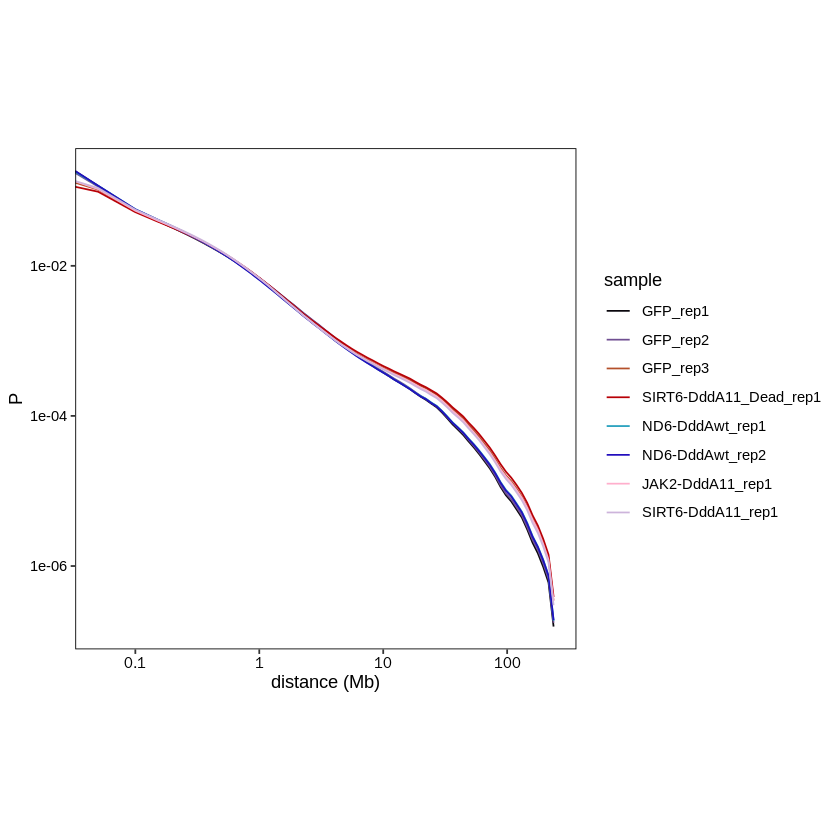

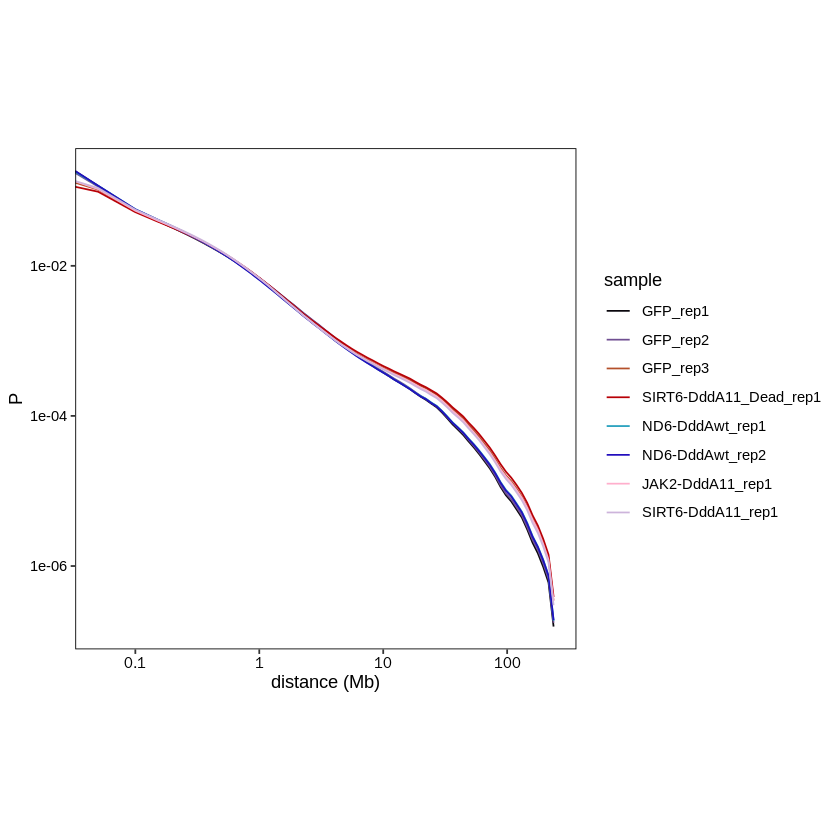

In [182]:
g1 <- visualise(RCP_out)
g1

ggsave('../genova_plots/04_RCP_genome-wide_raw_50k.pdf', g1, width=8, height = 6)


g2 <- visualise(RCP_out, smooth = T)
g2

ggsave('../genova_plots/04_RCP_genome-wide_smooth_50k.pdf', g2, width=8, height = 6)

#### Per chromosome

In [183]:
chr_list <- c(sprintf("chr%s",1:22), "chrX")
chr_list

[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX"

In [184]:
samples_50k <- list(
    matrix_GFP_rep1_50k,
    matrix_GFP_rep2_50k,
    matrix_GFP_rep3_50k, 
    matrix_SIRT6_DddA11_Dead_rep1_50k,
    matrix_ND6_DddAwt_rep1_50k,
    matrix_ND6_DddAwt_rep2_50k,
    matrix_JAK2_DddA11_rep1_50k,
    matrix_SIRT6_DddA11_rep1_50k
)

In [185]:
RCP_out <- RCP(
    explist = samples_50k,
    chromsToUse = chr_list
)

head(RCP_out$raw, 4)
head(RCP_out$smooth, 4)

P,region,distance,samplename,colour
<dbl>,<chr>,<dbl>,<fct>,<chr>
0.020075752,chr1,0,GFP_rep1,#0A070D
0.013437139,chr2,0,GFP_rep1,#0A070D
0.011121081,chr3,0,GFP_rep1,#0A070D
0.008278451,chr4,0,GFP_rep1,#0A070D


region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
chr1,0,0.020075752,GFP_rep1,#0A070D
chr1,50000,0.012959604,GFP_rep1,#0A070D
chr1,100000,0.006256812,GFP_rep1,#0A070D
chr1,150000,0.004543967,GFP_rep1,#0A070D


In [189]:
RCP_out$raw[RCP_out$raw$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'

RCP_out$smooth[RCP_out$smooth$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
# RCP_out$raw
# RCP_out$smooth

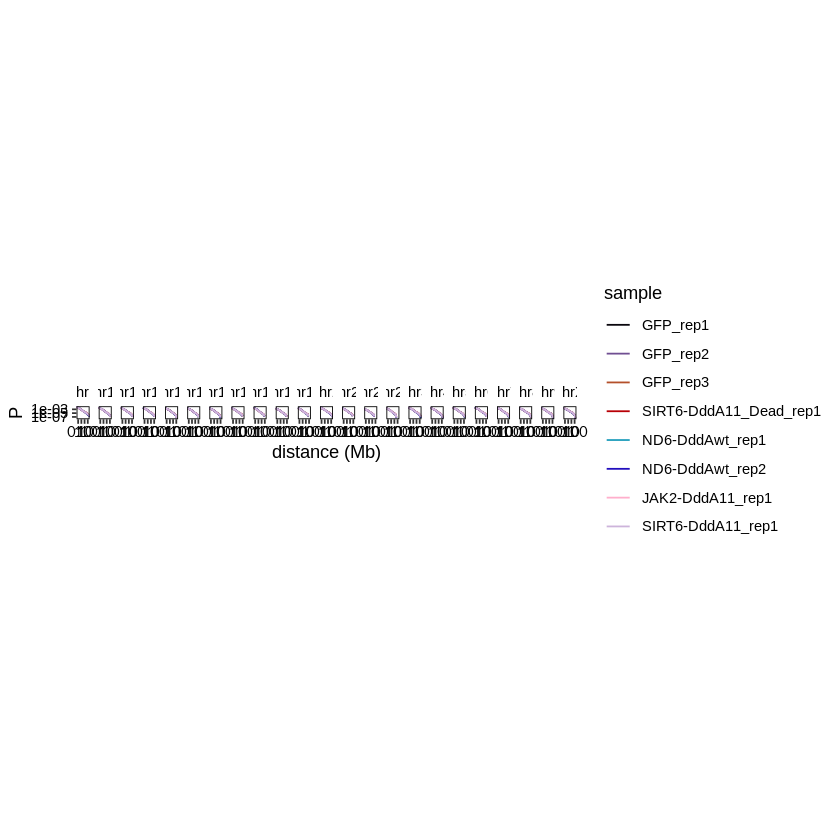

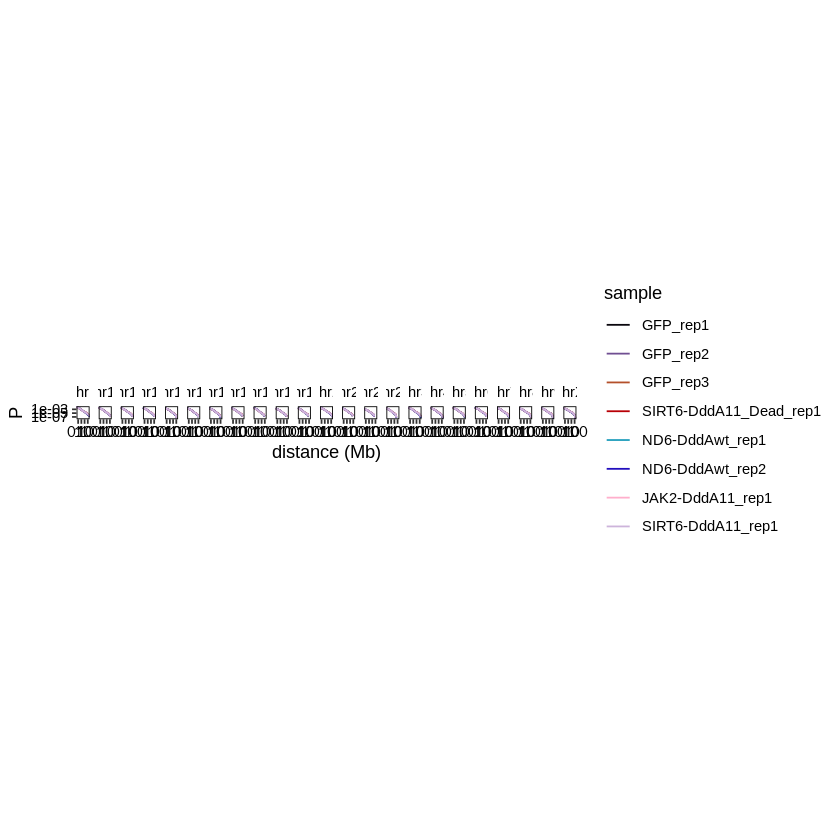

In [187]:
g1 <- visualise(RCP_out)
g1

ggsave('../genova_plots/04_RCP_per-chromosome_raw_50k.pdf', g1, width=30, height = 6)

g2 <- visualise(RCP_out, smooth = T)
g2
ggsave('../genova_plots/04_RCP_per-chromosome_smooth_50k.pdf', g2, width=30, height = 6)

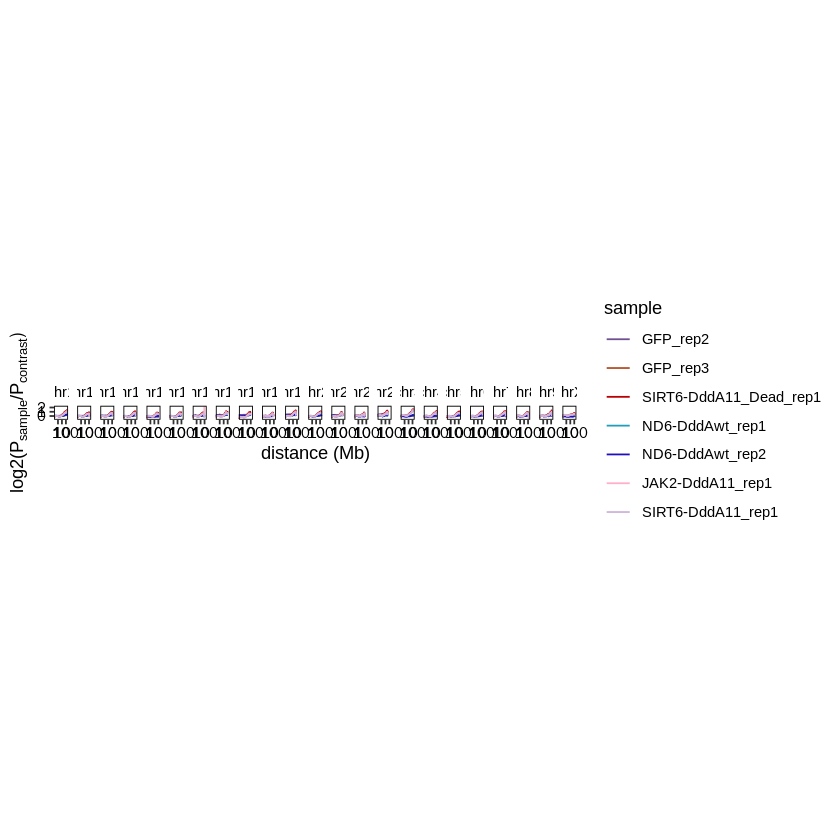

In [188]:
g3 <- visualise(RCP_out, contrast = 1, metric = 'lfc')
g3
ggsave('../genova_plots/05_RCP_contrast_fc_for_per-chromsome_raw_50k_all_vs_GFP_rep3.pdf', g3, width=20, height = 6)

### RCP lfc mode (Differentials \& Regions) 计算
We can directly compare samples to one another (for example WT versus WAPL). 

To plot this, the `metric` argument has to be set to `lfc` and `contrast` to 1, indicating the WT sample. 

This plots the log-fold change of average probabilities.

我们可以直接将样本相互比较（例如WT与WAPL）。

为了绘图，`metric`参数必须设置为`lfc`，`contrast`为1，表示WT样本（图5）。

这就绘制了平均概率的倍数变化。


```R
# Plot RCP: combined
visualise(RCP_out, contrast = 1, metric = 'lfc')
```


![](https://p.ipic.vip/k57p5f.png)


---

But what if you want to compare the contact probabilities of specific regions, like Cohesin- or CTCF-bound regions? 

For this purpose, we added the possibility to add a `list` of BED-`data.frame`s to the `bedList`-argument. 

Under the hood, we perform a standard per-arm RCP (thus still enabling users to set the `chromsToUse`-parameter). 

Thereafter, we filter out Hi-C bins that do not have entries in the `data.frame`(s) of `bedList`. The same plot-function `visualise()` can be used.

如果想要比较特定 regions 的 contact，比如 Cohesion 和 CTCF-binding regions 呢？

为了这个目的，我们需要将 possibility 加上一个 list 对象，这个对象中包含一个 BED 格式的`data.frame`，使用`bedList`参数。

在 Region 的限定下，这里测试了一个标准的 per-arm RCP（因此仍然允许用户设置`chromsToUse`参数）

然后，我们过滤掉在`bedList`的`data.frame(s)`中没有条目的Hi-C bins。

可以使用相同的plot函数`visualise()`。



```R
CTCF = read.delim('../data/symlinks/CTCF_WT_motifs.bed', header = FALSE)
SMC1 = read.delim('../data/symlinks/SMC1_WT_peaks.narrowPeak', header = FALSE)
RCP_out = RCP(list(Hap1_WT_40kb, Hap1_WAPL_40kb),
              bedlist =  list("CTCF" = CTCF, 
                              'Cohesin' = SMC1), 
              chromsToUse = 'chr1')
visualise(RCP_out)
visualise(RCP_out, contrast = 1, metric = 'lfc')
```


![](https://p.ipic.vip/ptrl6y.png)

这里可以拿 off-target 当 list 来研究是否在不同的处理下，其远、近距离的 contact distant 会发生变化

#### Load aim regions (e.g. off-target list, ctcf-binding regions)

In [190]:
# 无法再指定 chr_list，因为已经指定了感兴趣的 bedlist
# 可以指定chr_list，不报错，但是无效

In [191]:
tb_ND6_IND <- read_tsv(
    "~/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1_ATP8_JAK2_SIRT6/tables/2022-11-25_old_650_ND456.bed",
    col_names = c('chromosome', 'start', 'stop', 'name'),
    show_col_types = F
) %>% filter(grepl('ND6', name)) %>% select(chromosome, start, stop)
            
tb_ctcf <- read_tsv(
    "~/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1_ATP8_JAK2_SIRT6/tables/ENCFF285QVL_CTCF_binding_sites_fix_range.bed",
    col_names = c('chromosome', 'start', 'stop', 'name', 'score'),
    show_col_types = F
) %>% select(chromosome, start, stop)

# tb_random <- read_tsv( # 3000 random regions
#     "~/3.project/2022_DdCBE-3D-Genome_topic/2023-01-16_HiC_batch-1_2/tables/hg38_random_seed_123_n_3000.bed",
#     col_names = c('chromosome', 'start', 'stop'),
#     show_col_types = F
# ) %>% select(chromosome, start, stop)
head(tb_ctcf, 3)
head(tb_ND6_IND, 3)
# head(tb_random, 3)

chromosome,start,stop
<chr>,<dbl>,<dbl>
chr10,127196833,127197257
chr2,216015147,216015571
chr11,18394671,18395095


chromosome,start,stop
<chr>,<dbl>,<dbl>
chr1,9702414,9702449
chr1,13019998,13020019
chr1,13354705,13354738


In [192]:
# 第一个 sample 会被视为 control（分母）

samples_50k <- list(
    matrix_GFP_rep1_50k, # ctrl
    matrix_GFP_rep2_50k,
    matrix_GFP_rep3_50k, 
    matrix_SIRT6_DddA11_Dead_rep1_50k,
    matrix_ND6_DddAwt_rep1_50k,
    matrix_ND6_DddAwt_rep2_50k,
    matrix_JAK2_DddA11_rep1_50k,
    matrix_SIRT6_DddA11_rep1_50k
)

In [193]:
RCP_out <- RCP(
    explist = samples_50k,
    genomeWide = T
)
head(RCP_out$raw, 4)

region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
genome-wide,0,0.1813363,GFP_rep1,#0A070D
genome-wide,0,0.1725810,GFP_rep2,#704F92
genome-wide,0,0.1279199,GFP_rep3,#B4502A
genome-wide,0,0.1129469,SIRT6-DddA11_Dead_rep1,#B80006


In [194]:
RCP_out$raw[RCP_out$raw$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
RCP_out$smooth[RCP_out$smooth$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
# RCP_out$raw
# RCP_out$smooth

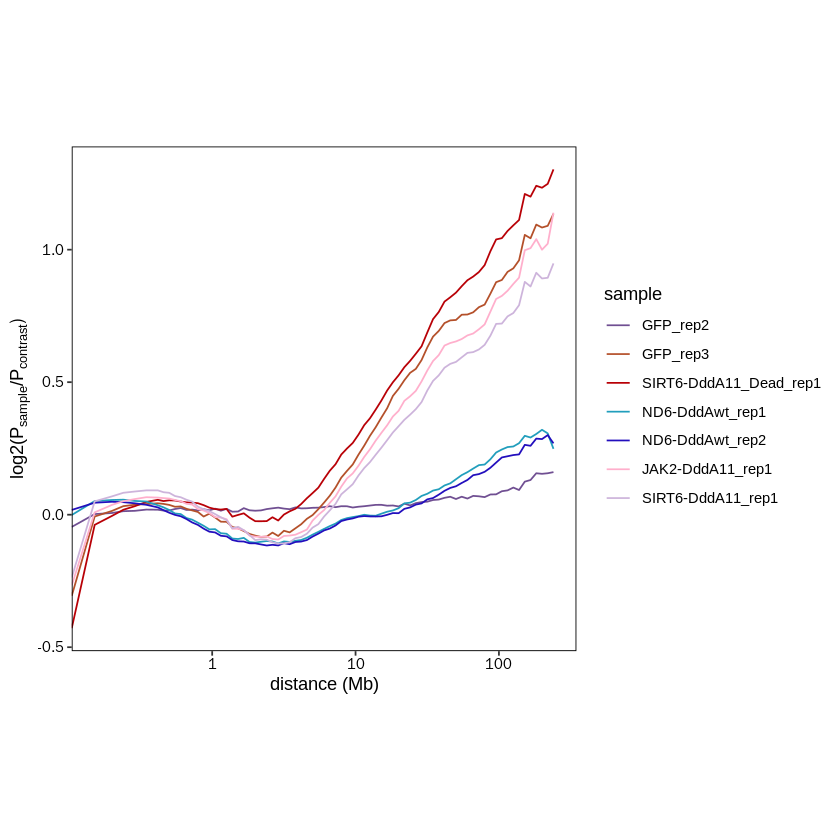

In [195]:
# genome-wide
g <- visualise(RCP_out, contrast = 1, metric = 'lfc')
g
ggsave('../genova_plots/05_RCP_contrast_fc_for_genome-wide_raw_50k.pdf', g, width=8, height = 6)

In [196]:
samples_50k <- list(
    matrix_GFP_rep1_50k, # ctrl
    matrix_GFP_rep2_50k,
    matrix_ND6_DddAwt_rep1_50k,
    matrix_ND6_DddAwt_rep2_50k
)

RCP_out <- RCP(
    explist = samples_50k,
    bedlist = list(
        "ND6_IND"=as.data.frame(tb_ND6_IND),
        "CTCF"=as.data.frame(tb_ctcf)
    )
)
head(RCP_out$raw, 4)

region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
ND6_IND,0,0.1924066,GFP_rep1,#0A070D
ND6_IND,0,0.1818711,GFP_rep2,#704F92
ND6_IND,0,0.1354961,GFP_rep3,#B4502A
ND6_IND,0,0.1198256,SIRT6-DddA11_Dead_rep1,#B80006


In [197]:
RCP_out$raw[RCP_out$raw$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
RCP_out$smooth[RCP_out$smooth$samplename == 'ND6-DddAwt_rep2', 'colour'] <- '#220ebd'
# RCP_out$raw
# RCP_out$smooth

In [207]:
# all_raw <- RCP_out$raw
# all_smooth <- RCP_out$smooth
# RCP_out$raw <- RCP_out$raw %>% filter(!samplename %in% c('GFP_rep3', 'SIRT6-DddA11_Dead_rep1', 'JAK2-DddA11_rep1', 'SIRT6-DddA11_rep1'))
# RCP_out$smooth <- RCP_out$smooth %>% filter(!samplename %in% c('GFP_rep3', 'SIRT6-DddA11_Dead_rep1', 'JAK2-DddA11_rep1', 'SIRT6-DddA11_rep1'))

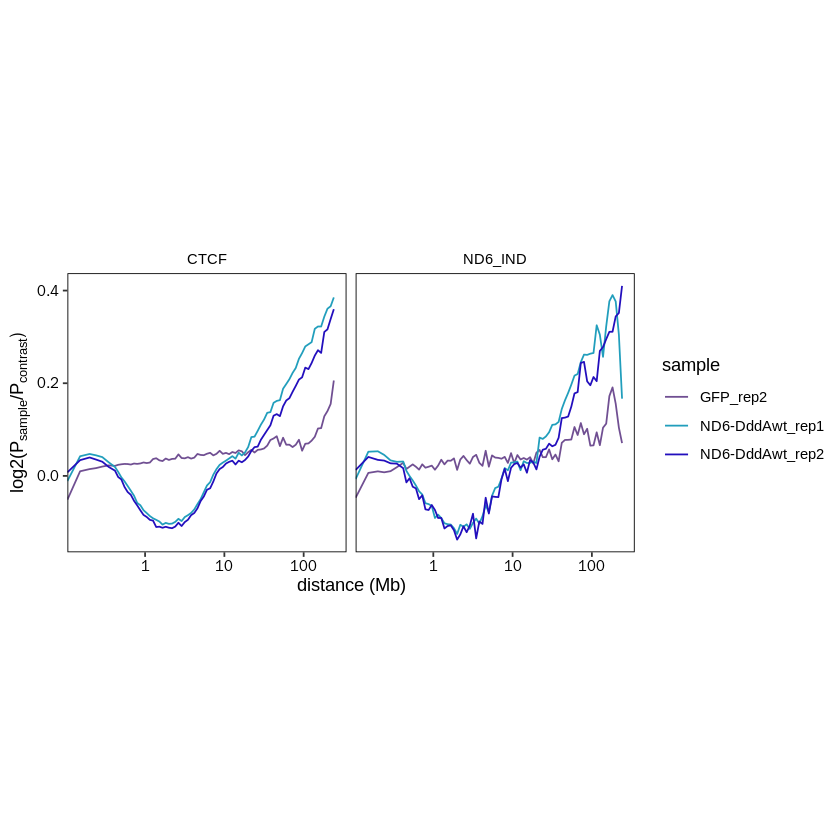

In [200]:
# bedlist (aim regions)
g <- visualise(RCP_out, contrast = 1, metric = 'lfc')
g
ggsave('../genova_plots/05_RCP_contrast_fc_for_aim-regions_raw_50k_old.pdf', g, width=8, height = 6)

In [205]:
samples_50k <- list(
    matrix_GFP_rep3_50k, 
    matrix_SIRT6_DddA11_Dead_rep1_50k,
    matrix_JAK2_DddA11_rep1_50k,
    matrix_SIRT6_DddA11_rep1_50k
)
RCP_out <- RCP(
    explist = samples_50k,
    bedlist = list(
        "ND6_IND"=as.data.frame(tb_ND6_IND),
        "CTCF"=as.data.frame(tb_ctcf)
    )
)
head(RCP_out$raw, 4)

region,distance,P,samplename,colour
<chr>,<dbl>,<dbl>,<fct>,<chr>
ND6_IND,0,0.1354961,GFP_rep3,#B4502A
ND6_IND,0,0.1198256,SIRT6-DddA11_Dead_rep1,#B80006
ND6_IND,0,0.1425497,JAK2-DddA11_rep1,#ffafcc
ND6_IND,0,0.1436965,SIRT6-DddA11_rep1,#cdb4db


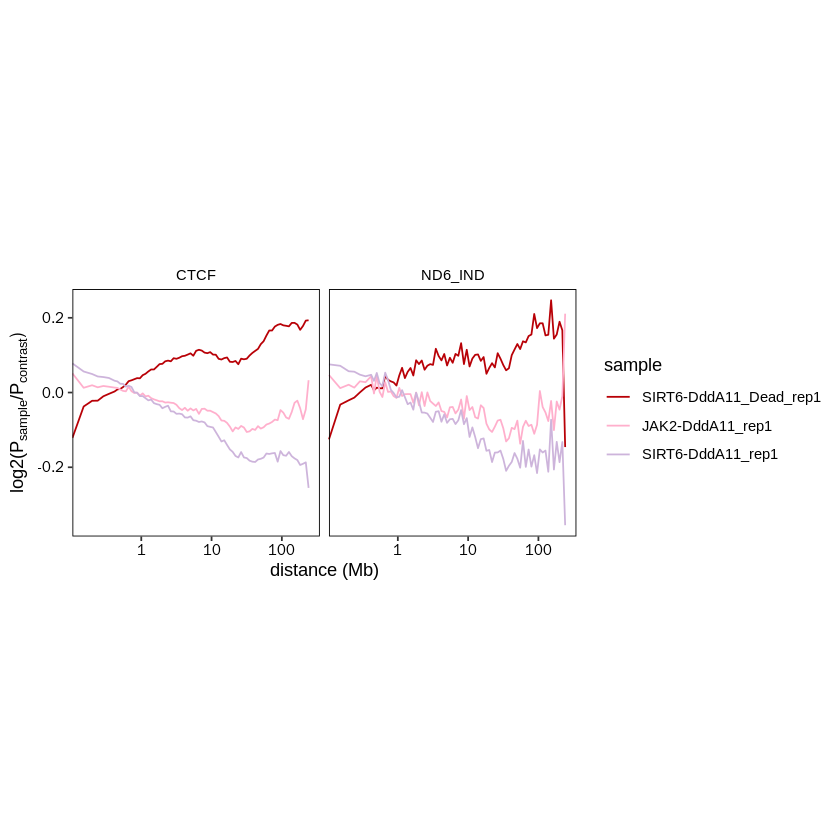

In [206]:
# bedlist (aim regions)
g <- visualise(RCP_out, contrast = 1, metric = 'lfc')
g
ggsave('../genova_plots/05_RCP_contrast_fc_for_aim-regions_raw_50k_new.pdf', g, width=8, height = 6)

## A- and B-compartments
Dividing chromosomes into A- and B-compartments requires the calculation of a compartment score along with information about what parts of the genome are active. To infer which compartment is A (viewed as the active state) and which is B, we can add a BED-`data.frame` of ChIP-seq peaks from active histone marks (e.g. H3K27ac, H3K4me1). Below, we can use the `compartment_score()` function with H3K27ac peaks to distinguish the compartments. The compartment score uses the first eigenvector of an eigendecomposition on the distance-dependant observed/expected matrix to get an unsigned compartment score.  This score is then correlated to H3K27ac presence to yield signed compartment scores that can be interpreted as A compartments when positive and B compartments when negative.

- 将染色体分为A-compartments和B-compartments需要计算一个compartment score，同时还要计算基因组哪些部分是活跃的。
- 为了推断哪个区段是A-compartments（被视为活跃状态），哪个区段是B-compartments，我们可以添加一个来自活跃组蛋白标记（如H3K27ac，H3K4me1）的ChIP-seq peak的BED-data.frame。
- 下面，我们可以用H3K27ac峰的 `compartment_score()`函数来区分各个compartments。
- `compartment_score()`使用了distance-dependant observed/expected matrix的第一个特征向量，以得到一个无符号的compartment score。
- 然后将该分数与H3K27ac的存在相关联，得到有符号的compartment score
    - 在阳性(+)时可解释为A-compartment
    - 在阴性(-)时可解释为B-compartment


```R
H3K27acPeaks = read.delim('../data/symlinks/H3K27ac_WT.narrowPeak', 
                          header = FALSE)
CS_out = compartment_score(list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
                           bed = H3K27acPeaks)
visualise(CS_out, chr = "chr17")
```

In [457]:
# from encode
# the same as mhw bed file
H3K27acPeaks = read.delim('~/1.database/public_data/HEK293-HG38_H3K27ac_narrowPeak_ENCFF451UZW.bed')
# H3K27acPeaks = read.delim('~/1.database/public_data/HEK293T_HG38_H3K27ac_narrowPeak_ENCFF594VZB.bed')
H3K4me1Peaks = read.delim('~/1.database/public_data/HEK293T_HG38_H3K4me1_narrowPeak_ENCFF301UTR.bed')

In [360]:
    # matrix_GFP_rep3_200k
    # matrix_SIRT6_DddA11_Dead_rep1_200k,
    # matrix_JAK2_DddA11_rep1_200k,
    # matrix_SIRT6_DddA11_rep1_200k,
    # matrix_GFP_rep1_200k,
    # matrix_GFP_rep2_200k,
    # matrix_ND6_DddAwt_rep1_200k,
    # matrix_ND6_DddAwt_rep2_200k

In [361]:
# df1 <- matrix_GFP_rep3_200k$IDX%>% mutate(V2 = tolower(V2), V3 = tolower(V3)) %>% unite(idx, V1, V2, V3)
# df2 <- matrix_SIRT6_DddA11_Dead_rep1_200k$IDX%>% mutate(V2 = tolower(V2), V3 = tolower(V3)) %>% unite(idx, V1, V2, V3)
# left_join(df1, df2, by='idx') %>% filter(V4.x != V4.y)

In [362]:
# ?unite

In [363]:
samples_100k <- list(
    matrix_GFP_rep3_100k,  # ctrl
    matrix_SIRT6_DddA11_Dead_rep1_100k,
    matrix_JAK2_DddA11_rep1_100k,
    matrix_SIRT6_DddA11_rep1_100k,
    matrix_GFP_rep1_100k,
    matrix_GFP_rep2_100k,
    matrix_ND6_DddAwt_rep1_100k,
    matrix_ND6_DddAwt_rep2_100k
)

In [364]:
c_idx <- c()
for(mat in samples_200k){
    c_idx <- c(c_idx, tail(mat$IDX, 1)$V4)
}
min(c_idx)

[1] 14801

In [383]:
matrix_GFP_rep3_100k$IDX <- matrix_GFP_rep3_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_SIRT6_DddA11_Dead_rep1_100k$IDX <- matrix_SIRT6_DddA11_Dead_rep1_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_JAK2_DddA11_rep1_100k$IDX <- matrix_JAK2_DddA11_rep1_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_SIRT6_DddA11_rep1_100k$IDX <- matrix_SIRT6_DddA11_rep1_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_GFP_rep1_100k$IDX <- matrix_GFP_rep1_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_GFP_rep2_100k$IDX <- matrix_GFP_rep2_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_ND6_DddAwt_rep1_100k$IDX <- matrix_ND6_DddAwt_rep1_100k$IDX %>% filter(V4 <= min(c_idx))
matrix_ND6_DddAwt_rep2_100k$IDX <- matrix_ND6_DddAwt_rep2_100k$IDX %>% filter(V4 <= min(c_idx))

In [384]:
tail(matrix_GFP_rep3_100k$IDX, 1)
tail(matrix_GFP_rep2_100k$IDX, 1)
tail(matrix_ND6_DddAwt_rep2_100k$IDX, 1)

tail(matrix_GFP_rep1_100k$IDX, 1)
tail(matrix_ND6_DddAwt_rep1_100k$IDX, 1)

tail(matrix_SIRT6_DddA11_Dead_rep1_100k$IDX, 1)
tail(matrix_SIRT6_DddA11_rep1_100k$IDX, 1)
tail(matrix_JAK2_DddA11_rep1_100k$IDX, 1)

V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,88900000,89000000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,88900000,89000000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,88900000,89000000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,89000000,89100000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,89000000,89100000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,88900000,89000000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,88900000,89000000,14801


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chr8,89000000,89100000,14801


In [388]:
samples_100k <- list(
    matrix_GFP_rep3_100k,  # ctrl
    # matrix_SIRT6_DddA11_Dead_rep1_100k,
    # matrix_JAK2_DddA11_rep1_100k,
    matrix_SIRT6_DddA11_rep1_100k,
    # matrix_GFP_rep1_100k,
    matrix_GFP_rep2_100k,
    # matrix_ND6_DddAwt_rep1_100k,
    matrix_ND6_DddAwt_rep2_100k
)

In [389]:
# 很慢
CS_out = compartment_score(
    samples_100k,
    bed = H3K27acPeaks
)

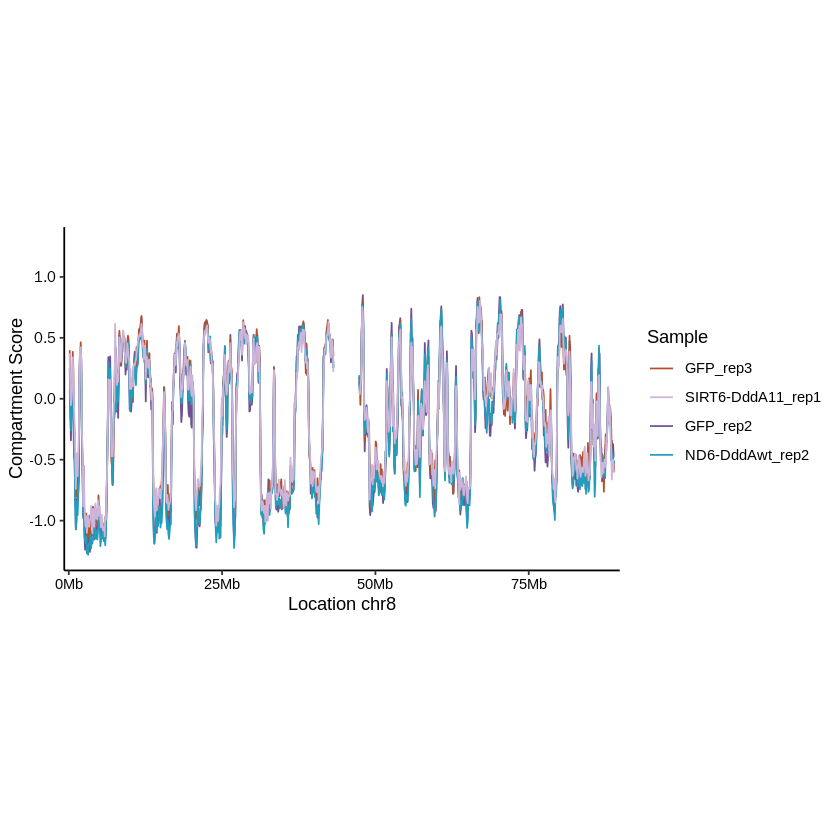

In [390]:
g <- visualise(CS_out, chr='chr8')
g

In [391]:
head(CS_out$compart_scores)

,chrom,start,end,bin,GFP_rep3,SIRT6-DddA11_rep1,GFP_rep2,ND6-DddAwt_rep2
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,0,100000,1,0.3007014,0.3029844,0.4237025,0.4603414
2,chr1,100000,200000,2,0.3382352,0.3289489,0.4404877,0.3976821
3,chr1,200000,300000,3,0.3382513,0.2999641,0.4918892,0.5278452
4,chr1,300000,400000,4,0.2816404,0.3190953,0.4653716,0.5425000
5,chr1,400000,500000,5,0.2814531,0.3202229,0.4668092,0.5441629
6,chr1,500000,600000,6,0.5143231,0.4173301,0.5076163,0.3897915


In [392]:
ggsave('../genova_plots/06_compartment_score_for_genome-wide_raw_100k.pdf', g, width=8, height = 6)

### Saddle-analyses
To illustrate the self-preference of compartments, one can use the `saddle()` function to perform a compartment score 'quantile versus quantile' analysis. Every chromosome arm is divided into quantiles based on the compartment score, and distance dependent observed over expected is computed. Every combination of quantile bins is then averaged to produce the saddle analysis.

为了说明区室的自我偏好，可以使用`saddle()`函数来进行区室得分'量级对量级'分析。每条染色体臂都根据区间得分被划分为量级，并计算出观察到的与预期的距离。然后对每个量化分值的组合进行平均，以产生鞍状分析。为了说明区室的自我偏好，可以使用`saddle()`函数来进行区室得分'量级对量级'分析。每条染色体臂都根据区间得分被划分为量级，并计算出观察到的与预期的距离。然后对每个量化分值的组合进行平均，以产生鞍状分析。

```R
saddle_out = saddle(list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
                   CS_discovery = CS_out,
                   bins = 50)
visualise(saddle_out)
```

In [393]:
saddle_out = saddle(
    samples_100k,
    CS_discovery = CS_out,
    bins = 50
)

[1] 7.488636

[1] 0

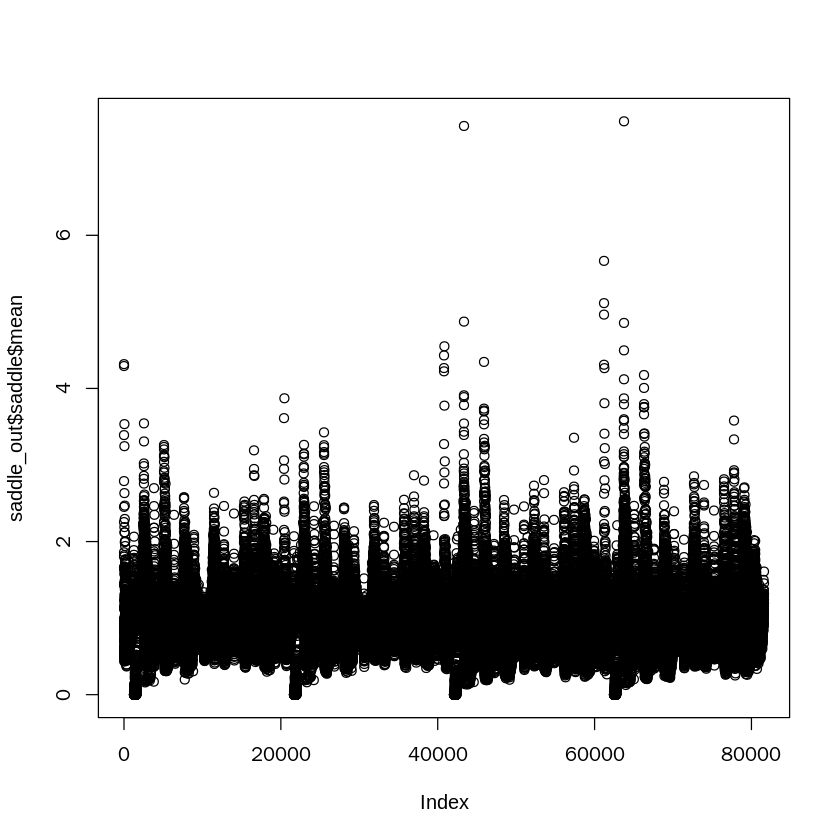

In [394]:
# saddle_out$saddle
max(saddle_out$saddle$mean)
min(saddle_out$saddle$mean)
plot(saddle_out$saddle$mean)

In [ ]:
visualise(saddle_out)

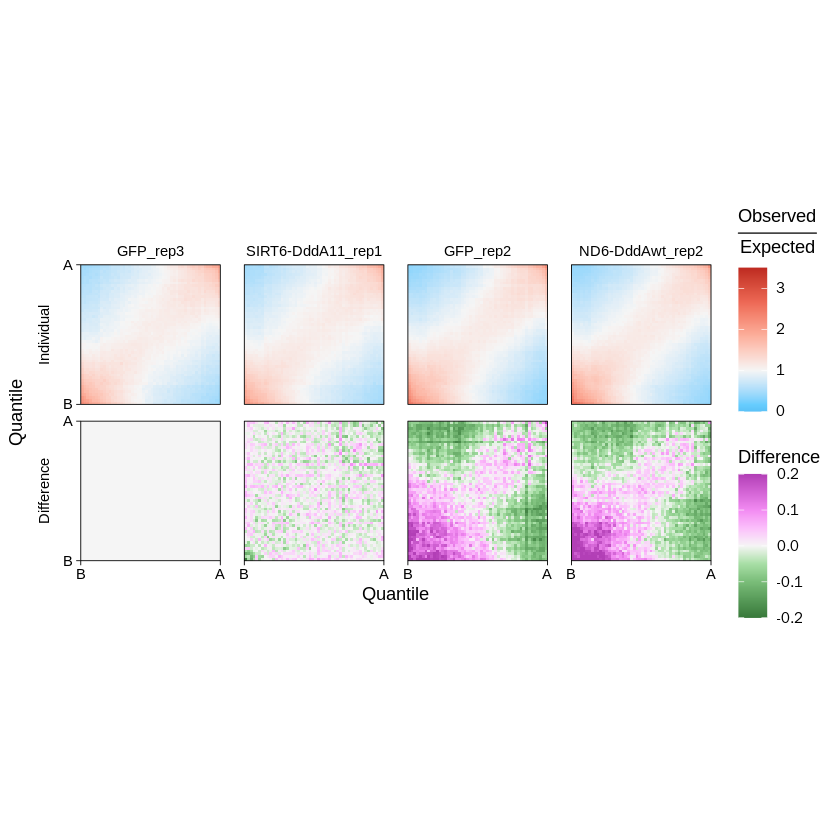

In [399]:
g <- visualise(saddle_out, genomeWide=TRUE, 
               colour_lim=c(0, 3.5), colour_lim_contrast=c(-0.2, 0.2))
g

In [396]:
ggsave('../genova_plots/07_compartment_score_quantile_versus_quantile_raw_100k_new.pdf', g, width=10, height = 6)

In [397]:
head(CS_out$compart_scores)

,chrom,start,end,bin,GFP_rep3,SIRT6-DddA11_rep1,GFP_rep2,ND6-DddAwt_rep2
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,0,100000,1,0.3007014,0.3029844,0.4237025,0.4603414
2,chr1,100000,200000,2,0.3382352,0.3289489,0.4404877,0.3976821
3,chr1,200000,300000,3,0.3382513,0.2999641,0.4918892,0.5278452
4,chr1,300000,400000,4,0.2816404,0.3190953,0.4653716,0.5425000
5,chr1,400000,500000,5,0.2814531,0.3202229,0.4668092,0.5441629
6,chr1,500000,600000,6,0.5143231,0.4173301,0.5076163,0.3897915


In [398]:
write_csv(CS_out$compart_scores, 'tables/temp_table__compartment_score.csv')


# use python to filter data

### Compartment-strength
The output of the saddle analysis gives a starting point for calculating the compartment strength, which gives a score for how much A-A and B-B interactions occur versus A-B interactions. The comparment strength can be calculated using the `quantify()` function on the output of the `saddle()` function.

saddle analysis的输出为计算comparment strength提供了一个起点，它给出了A-A和B-B相互作用与A-B相互作用发生的程度的分数。

可以使用saddle()函数输出上的quantify()函数来计算comparment strength。

```R
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(WT, WAPL, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)
```

In [ ]:
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(GFP_rep3, `SIRT6-DddA11_rep1`, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)

In [ ]:
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(GFP_rep3, `JAK2-DddA11_rep1`, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)

In [ ]:
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(GFP_rep3, `SIRT6-DddA11_Dead_rep1`, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)

In [ ]:
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(`SIRT6-DddA11_Dead_rep1`, `SIRT6-DddA11_rep1`, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)

# Interaction plots
GENOVA has several plotting-functions for genomic loci. `compartment_matrixplot()` and *trans.compartment.plot* provide a easy way to plot whole chromosome arms, including compartmentalisation-score tracks. For more zoomed-in plots, `hic_matrixplot()` can be used. This function also allows rich annotation and between-experiment comparison possibilities. All functions try to guess the most appropriate colour-scale limits, but finer control of this can be gotten by setting the `colour_lim`-argument.

GENOVA有几个针对基因组位点的绘图功能：
- `compartment_matrixplot()`和`trans.compartment.plot`提供了一个简单的方法来绘制整个染色体臂，包括区隔化分数的轨迹。
- 对于更多的放大图，可以使用`hic_matrixplot()`,这个函数也允许丰富的注释和实验间比较的可能性。

- 所有的函数都试图猜测最合适的颜色比例限制，但是可以通过设置`colour_lim`参数得到更精细的控制。

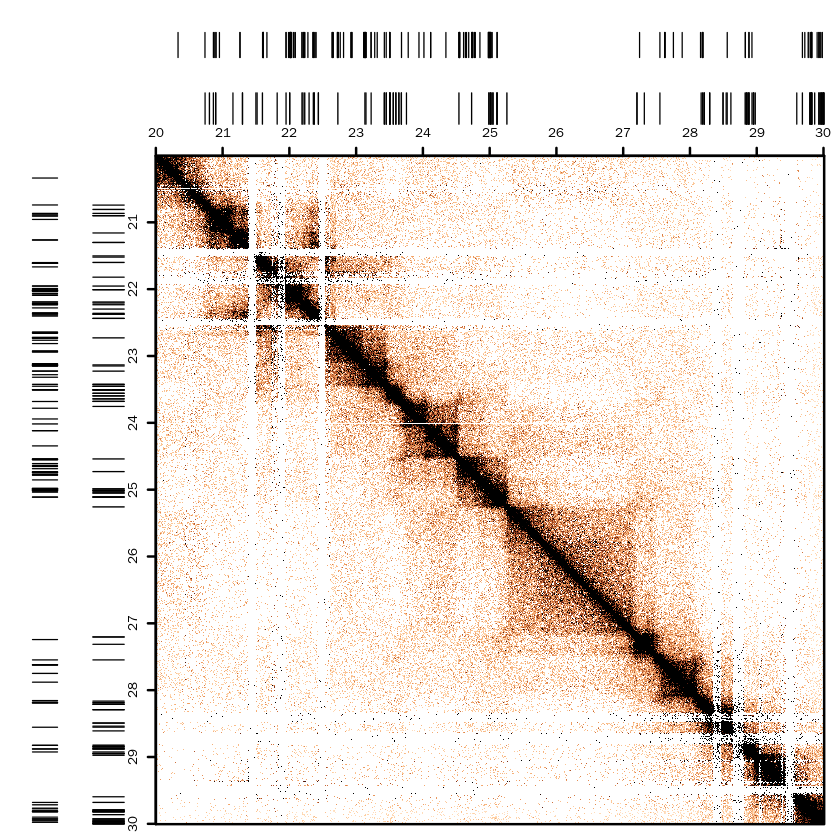

In [460]:
# chr16	2927219	2927248	ND4-Extend-11_ND5.1-TAS.IND-352_ND6-TAS.IND-415_chr16_2927219_2927248	10	+
hic_matrixplot(
    # matrix_GFP_rep3_100k,
    matrix_SIRT6_DddA11_rep1_10k,
    chrom='chr16',
    start=20000000,
    end=30000000,
    cut.off = 20,
    chip = list('H3K27acPeaks'=H3K27acPeaks, 'H3K4me1Peaks'=H3K4me1Peaks)
)

In [454]:
# ?hic_matrixplot

hic_matrixplot {GENOVA},R Documentation
exp1,The Hi-C experiment object: produced by construct.experiment().
exp2,Optional: a Hi-C experiment object.
chrom,"Chromosome of the region of interest. Alternatively one of the following: A 3-column, 1-row data.frame in BED-format. A single character describing a locus in UCSC notation, e.g. ""chr1:30,000,000-35,000,000"" The latter two options automatically provide the start and end arguments too."
"start, end",Start and end position of the region of interest. Ignored if the chrom argument is a BED-format data.frame.
"colour_lim, cut.off",A numeric of length 2 for the lower and upper colour limits of the hic-matrix plot. cut.off: older syntax.
chip,"A list of feature tracks, can be bed structure (i.e. data frames) or a path to bigwig file (i.e. character variable), maximum length of 4. Placement is inner-top, outer-top, outer-left, inner-left."
inferno,White/Red/black or White/Red coloscale?
cexTicks,Change size of numbers on the axis
chip.colour,"A vector of four, parallel to [chip], of the to use colour."
chip.yMax,"A vector of four, parallel to [chip], of the maximum height of the biwigs. If only one value is given, all be set on this value."


## *Cis*-interactions 
The compartmentalisation of the chromatin into A and B van already described in the original Hi-C paper [@Lieberman-Aiden2009]. Serval papers have described the loss of compartmentalisation when the Cohesin complex is stabalised [@Haarhuis2017,@Wutz2017,@Gassler2017]. To view this interesting level of chromatin organisation, we can use `compartment_matrixplot()`. This function can plot one arm of a chromosome with the compartment-score plotted above.  In figure \@ref(fig:CCP1) you can see the resulting plots, where you can see that the chequerboard-pattern in the matrix and the amplitude of the compartment-score are diminished in the WAPL-knockout.
```{r CCP1, out.width='.49\\linewidth', fig.show='hold',fig.align='center', message=FALSE , fig.asp=1,fig.cap= "Cis compartment plot: WT vs WAPL. Stabilised Cohesin-mediated loops by WAPL-knockout leads to loss of compartments.",dev = 'png', dpi=300,cache=F}
compartment_matrixplot(
  exp1 = Hap1_WT_40kb,
  exp2 = Hap1_WAPL_40kb,
  CS_discovery = CS_out,
  chrom = "chr14", arm = "q",
  colour_lim = c(0, 15)
)
```

The compartment-score is calculated by performing an eigenvector decomposition on the correlation-matrix of the expected over expected matrix. To view this observed over expected matrix, we can set the `metric`-option to `"obsexp"`. Alternatively, we can set `metric = "correlation"` to view the Pearson correlation of the observed over expected matrix. These metrics gives a visually better indication of the A- and B-compartments (figure \@ref(fig:CCP3)). 
```{r CCP3, message=FALSE , fig.asp=1,fig.cap= "Cis compartment plot. Observed over expected.",dev = 'png', dpi=300,cache=F, fig.retina=T, fig.small = T}
compartment_matrixplot(
  exp1 = Hap1_WT_40kb,
  exp2 = Hap1_WAPL_40kb,
  CS_discovery = CS_out,
  chrom = "chr20", arm = "q",
  metric = "log2obsexp"
)
```

In [433]:
compartment_matrixplot(
    matrix_GFP_rep3_100k,
    matrix_SIRT6_DddA11_rep1_100k,
    CS_discovery = CS_out,
    chrom = "chr14", 
    arm = "q",
  colour_lim = c(0, 15)
)
# ?compartment_matrixplot

ERROR: Error in compartment_matrixplot(matrix_GFP_rep3_100k, matrix_SIRT6_DddA11_rep1_100k, : No `q` arm found. Try the other, or "all" option.


## *Trans*-interactions 
The function `trans_matrixplot()` will allow the user to plot a trans-matrix (i.e. a matrix of the arms of two different chromosomes). This function could also be used to investigate chromosomal translocations: the $\text{9q;22q}$ translocation can be clearly seen if we use this function, as in figure \@ref(fig:TCP).
```{r TCP, message=FALSE , fig.asp=1,fig.cap= "Trans compartment plot. The t(9q;22q) translocation is easily identified.",dev = 'png', dpi=300,cache=F, fig.retina=T, fig.small = T}
trans_matrixplot(
  Hap1_WT_40kb,
  chrom_up = "chr9", start_up = 100e6, end_up = 140e6,
  chrom_down = "chr22", start_down = 16e6, end_down = 40e6,
  colour_lim = c(0, 20)
)
```

## Matrix plots
To produce richly annotated zoomed-in (i.e. max 10Mb) plots of specific regions, we use the `hic_matrixplot()` function. In this, we can use one or two experiment objects: two can be shown either in diff-mode (the difference between the two) or upper/lower triangle mode. TAD- and loop-annotations can be added, as well as bigwig- and bed-tracks. Moreover, genemodel-files can be added. In this section, we will build up to a final, fully annotated, matrix from a humble one-experiment plot (figure \@ref(fig:HMP1)).

- 为了产生特定区域的丰富注释的放大（即最大10Mb）图，我们使用`hic_matrixplot()`函数。
- 在此，我们可以使用一个或两个实验对象：两个实验对象可以用diff模式（两个实验对象的差异）或上/下三角模式显示。
- 可以添加TAD-和循环注释，以及bigwig-和bed-track。此外，还可以添加基因模型文件。
- 在本节中，我们将从一个简陋的单实验图（图/@ref(fig:HMP1)）中建立起一个最终的、完全注释的矩阵。

```R
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               cut.off = 50) # upper limit of contacts
```

### Two experiments
Adding a second experiment will give us the option of `coplot`, which can be `dual` (default) or `diff`. The left plot shows the WT sample in the upper triangle and KO sample in the lower. In the right plot, the KO sample is subtracted from the WT in `diff`-mode: red is therefore more contacts in the KO and blue denotes more contacts in the WT (figure \@ref(fig:HMPdiff1)).

- 添加第二个实验会给我们提供`coplotcoplot`的选项，可以是 `dualdual`（默认）或`diffdiff`。
- 左边的图显示上方三角形的WT样本和下方的KO样本。
- 在右图中，KO样本在 "差异 "模式下被减去WT样本: 因此红色表示KO样本有更多的接触，蓝色表示WT样本有更多的接触。

```R
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_WAPL_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               cut.off = 50) # upper limit of contacts
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_WAPL_10kb,
               coplot = 'diff',
               chrom = 'chr7',
               start = 25e6,
               end=30e6, # upper limit of contacts
               cut.off = 25) 
```

In [421]:
hic_matrixplot(exp1 = matrix_GFP_rep3_10k,
               exp2 = matrix_SIRT6_DddA11_rep1_10k,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               cut.off = 300) # upper limit of contacts

Warning message in exp1$IDX[["V4"]] == exp2$IDX[["V4"]]:
“长的对象长度不是短的对象长度的整倍数”


ERROR: Error in hic_matrixplot(exp1 = matrix_GFP_rep3_10k, exp2 = matrix_SIRT6_DddA11_rep1_10k, : Not all ICE indexes are the same.
Are you these experiments were mapped to the same genome (-build)?


In [432]:
hic_matrixplot(exp1 = matrix_SIRT6_DddA11_rep1_10k,
               exp2 = matrix_GFP_rep3_10k,
               coplot = 'diff',
               chrom = 'chr7',
               start = 25e6,
               end=30e6, # upper limit of contacts
               cut.off = 400) 

Warning message in exp1$IDX[["V4"]] == exp2$IDX[["V4"]]:
“长的对象长度不是短的对象长度的整倍数”


ERROR: Error in hic_matrixplot(exp1 = matrix_SIRT6_DddA11_rep1_10k, exp2 = matrix_GFP_rep3_10k, : Not all ICE indexes are the same.
Are you these experiments were mapped to the same genome (-build)?


In [430]:
tail(matrix_GFP_rep3_10k$IDX, 1)
tail(matrix_GFP_rep2_10k$IDX, 1)
tail(matrix_ND6_DddAwt_rep2_10k$IDX, 1)

tail(matrix_GFP_rep1_10k$IDX, 1)
tail(matrix_ND6_DddAwt_rep1_10k$IDX, 1)

tail(matrix_SIRT6_DddA11_Dead_rep1_10k$IDX, 1)
tail(matrix_SIRT6_DddA11_rep1_10k$IDX, 1)
tail(matrix_JAK2_DddA11_rep1_10k$IDX, 1)

V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrX,155690000,155700000,295936


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrY,56880000,56890000,283125


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrX,155690000,155700000,295923


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrY,56880000,56890000,301310


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrX,155690000,155700000,295923


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrY,56880000,56890000,301245


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrY,56880000,56890000,301271


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
chrY,56880000,56890000,301238


### TADs and loops
It can be very useful to annotate the matrix with the positions of TADs and loops: take, for example, the situation where these structures are altered in a knockout for example. We are going to use the TAD- and loop-calls of WT Hap1 20-kb matrices from Haarhuis et al. [-@Haarhuis2017], generated with HiCseg [@Levy-Leduc2014].

Lets load some TAD- and loop-annotations:
```{r loadLOOP_mp, cache=F}
WT_TADs  = read.delim('../data/symlinks/WT_hicseg_TADs.bed', h = F)
WT_Loops = read.delim('../data/symlinks/WT_HICCUPS.bedpe', h = F, skip = 1)
sanborn2015_Loops = read.delim('../data/symlinks/GSE74072_Hap1_HiCCUPS_looplist.txt.gz')
```

```{r fixLOOP_mp, echo = F, cache=F}
WT_Loops$V1 = gsub(pattern = "^", replacement = "chr", x = WT_Loops$V1) 
WT_Loops$V4 = gsub(pattern = "^", replacement = "chr", x = WT_Loops$V4)
WT_TADs = WT_TADs[!WT_TADs$V3 < WT_TADs$V2,] 
sanborn2015_Loops[,1] = gsub(sanborn2015_Loops[,1], pattern = "^", replacement = "chr")
sanborn2015_Loops[,4] = gsub(sanborn2015_Loops[,4], pattern = "^", replacement = "chr")
```

Add them to the plot by using the `tad`- and `loops`-arguments. Both can be plotted in one or both of the triangles and coloured as deemed appropriate (figure \@ref(fig:HMPtadloop)). Since loops are very small in a hic-matrixplot, they will be fully overlapped by the loop-annotations. To overcome this, we expand the annotations with a fixed distance in basepairs using `loops.resize`. This will draw a circle around the loop location. 
```{r HMPtadloop, out.width='.49\\linewidth', fig.show='hold',fig.align='center', fig.wide = T, message=FALSE , fig.cap= "Hi-C matrixplot: TAD- and loop-annotations from Haarhuis et al. (2017).",cache=F,fig.asp=1, dev = 'png', dpi=300}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               loops = WT_Loops, # see APA
               loops.colour = 'blue', # blue loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               tads = WT_TADs, # see ATA
               tads.type = 'lower', # only plot in lower triangle
               tads.colour = 'limegreen', # green TAD-borders
               cut.off = 25) # upper limit of contacts
```

### BigWigs and BEDs
Manipulation of CTCF-binding sites can result in loss or gain of loops and/or TADs [@DeWit2015a]. If you are interested in the effects of a knockout on the binding of a protein in combination with changes in interaction frequencies, adding ChIP-seq signal or -peaks to the matrix can be helpful. You can add up to two tracks above and two tracks to the left. These can be either BED-like `data.frame`s or the paths to the `.bw` files. For example, let's load a BED6-file (chrom, start, end, name, score, and strand ^[https://genome.ucsc.edu/FAQ/FAQformat.html]) of CTCF-motifs under CTCF-ChIP peaks. The argument `type` can be set to either *triangle* or *rectangle*. The triangle is nice to use if you want to look at the orientation of the BED-entries (figure \@ref(fig:HMPchip)). If you only have a three column BED, then the output will always be *rectangle*.
```{r CTCF, cache=F}
CTCF = read.delim('../data/symlinks/CTCF_WT_motifs.bed', h = F)
SMC1 = read.delim('../data/symlinks/SMC1_WT_peaks.narrowPeak', h = F)
```

```{r, echo =F }
knitr::kable(
  head(CTCF, 3), caption = 'A data.frame holding a standard BED6 format.'
)
```

Moreover, we can use a bigwig (.bw) file to plot a track. For this example, we are using a SMC1 ChIP-seq track from [@Haarhuis2017]. We load the bigwig data with the `rtracklayer` package that is available from Bioconductor. The `yMax` argument is handy if you want to compare bigwig-tracks: it lets you set the y-axis maximum.

```{r HMPchip, message=T , fig.cap= "Hi-C matrixplot: ChIPseq. A BED-file of CTCF-sites is plotted at the top and a coverage-track of SMC1 ChIP-seq is plotted beneath this. The symmAnn-option leads to the same tracks being plotted on the left.",cache=F,fig.asp=1, dev = 'png', dpi=300,fig.small = F}
requireNamespace("rtracklayer", quietly = TRUE)
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',  start = 26.75e6,  end=28.5e6, 
               loops = WT_Loops, # see APA
               loops.colour = 'purple', # purple loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               type = 'triangle',
               chip = list('../data/symlinks/SMC1_WT.bw', # inner top
                           CTCF),# outer-top
               symmAnn = F, # place annotations also on left side
               cut.off = 65) # upper limit of contacts
```

### Genes
[@Dixon2012] showed that housekeeping-genes are enriched in the vicinity of TAD-borders. Another interesting question could be whether differentially expressed genes are also found near TAD-borders or binding sites of specific proteins when studying a knockout. These type of questions can be tackled by adding the appropriate gene-models to `hic_matrixplot()`. To do this, we use a `data.fame`, where each row is an exon of a gene. There are several ways to get this, and one of the easier ways is to use biomart to get exon-coordinates. You could use the biomaRt-package or the web-based service. For this example, we downloaded data of all exons from the Ensembl biomart and plotted both the BED-file and the genes (figure \@ref(fig:HMPchipGene)).
```{r biomart}
# features downloaded:
## Gene stable ID & Transcript stable ID & Chromosome/scaffold name &
## Transcript start (bp) & Transcript end (bp) & Exon region start (bp) &
## Exon region end (bp) & Strand
# martExport = read.delim('../data/mart_export.txt.gz', stringsAsFactors = F)
# colnames(martExport) = c('ENSG','ENST','chrom' , # change column names
#                          'txStart' , 'txEnd' , 
#                          'exonStart' , 'exonEnd' , 'strand')
# martExport$chrom = gsub(martExport$chrom, # add chr-prefix
#                         pattern = '^',
#                         replacement = 'chr') 
# martExport$strand = ifelse(martExport$strand == 1, '+',"-") # 1/-1 to +/-
load('../data/symlinks/../martExport.RData_back')
```

```{r, echo =F }
knitr::kable(
  head(martExport[,-c(1,2)], 5), caption = 'A data.frame holding the needed columns for plotting genes.'
)
```


```{r HMPchipGene, message=FALSE , cache=F, fig.cap= "Hi-C matrixplot: genes.",fig.asp=1, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',  start = 26.75e6,  end=28.5e6, 
               genes = martExport,
               cut.off = 65) # upper limit of contacts
```

### Everthing together
Finally, we can combine all these options in one. This might put too much information in a single plot, but it can be quite handy. In this example, we can see that most TAD-borders and loop-anchors have clear SMC1- and CTCF-signal (figure \@ref(fig:HMPall)). Both these are expected to be found at these locations according to the *chromatin extrusion model*. Moreover, we can also see that the CTCF-orientation of the upstream and downstream loop-anchor are forward and reverse, respectively. This *convergent rule* is a known feature of loops [@DeWit2015]. 

```{r HMPall, message=FALSE , fig.cap= "Hi-C matrixplot: a complex case. Loops and TADs are annotated within the Hi-C matrix. On the top annotation-bar, we have plotted the ChIP-seq signal and peaks of SMC1. On the left annotation-bar are the ChIP-seq signal and peaks (with orientiation) of CTCF. Genes are plotted on both annotation-bars.",cache=F,fig.asp=1, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=28.5e6, 
               loops = WT_Loops, # see APA
               loops.colour = '#998ec3', # purple loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               genes = martExport,
               chip.colour = 'black',
               chip = list('../data/symlinks/SMC1_WT.bw', # inner-top
                           SMC1, # outer-top
                           '../data/symlinks/SMC1_WT.bw', # inner-left
                           CTCF), # outer-left
               tads = WT_TADs, # see ATA
               tads.type = 'lower', # only plot in lower triangle
               tads.colour = '#91cf60', # green TAD-borders
               cut.off = 50) # upper limit of contacts
```    

## Pyramid plots

In GENOVA, 'pyramid plots' are plots of a region in the Hi-C interaction map rotated at an 45 degree angle (figure \@ref(fig:pyramidBasic)). This rotation coincides the diagonal with the x-axis, and the y-direction indicates distance from the diagonal.

```{r, pyramidBasic, fig.cap= "A pyramid plot, showing a rotated Hi-C interaction map.",cache=F, dev = 'png', dpi=300}
pyramid(exp = Hap1_WT_10kb,
        chrom = 'chr7',
        start = 25e6,
        end=28.5e6,
        colour = c(0, 50))
```

Pyramid plots can be cropped in the x-and y-direction to make them more space efficient (figure \@ref(fig:pyramidRect)).

```{r, pyramidRect, fig.cap= "A cropped pyramid no longer looks like a pyramid.",cache=F, dev = 'png', dpi=300}
pyramid(exp = Hap1_WT_10kb,
        chrom = 'chr7',
        start = 25e6,
        end=28.5e6,
        crop_x = c(26e6, 27.5e6), # cropping in x direction uses locations
        crop_y = c(0, 2e6), # cropping in y direction uses distance
        colour = c(0, 50))
```

For comparing two different samples with pyramid plots, there are two options. The first option is to use `pyramid_difference()`, which works very similar to `pyramid()`, but takes two samples instead of one \@ref(fig:pyramidDiff)). 

```{r, pyramidDiff, fig.cap= "A pyramid plot showing the difference between two samples.",cache=F, dev = 'png', dpi=300}
pyramid_difference(
  Hap1_WT_10kb,
  Hap1_WAPL_10kb,
  chrom = "chr7", start = 25e6, end = 28.5e6
)
```

The alternative option is to stack the plots together using plot composition. Because `pyramid()` is based on the ggplot2 package, we can use the patchwork plot composition package to stack two (or more) plots \@ref(fig:pyramidPatch)).

```{r, pyramidPatch, fig.cap= "Using the patchwork package to stack pyramid plots.",cache=F, dev = 'png', dpi=300}
library(patchwork)
wt_pyramid <- pyramid(
  Hap1_WT_10kb,
  chr = "chr7", start = 25e6, end = 28.5e6,
  crop_y = c(0, 1.5e6),
  colour = c(0, 50)
) + ggplot2::ggtitle("Wildtype")
ko_pyramid <- pyramid(
  Hap1_WAPL_10kb,
  chr = "chr7", start = 25e6, end = 28.5e6,
  crop_y = c(0, 1.5e6),
  colour = c(0, 50)
) + ggplot2::ggtitle("WAPL KO")
ko_pyramid / wt_pyramid + plot_layout(guides = "collect")
```

# TADs
Topologically Associated Domains (TADs) are $\pm0.8-2\text{Mb}$ regions, which are seen as triangles in the matrix: regions that have more interactions within than outside. GENOVA has a repertoire of functions to generate and analyse TADs. Fist, we will use the insulation score to call TADs and compare the strength of TAD-borders between samples. Next, we will explore `ATA()` to analyse aggregates of TADs. Finally, we'll investigate whether TADs interact with their neighbouring TADs.

## Insulation
To estimate the strength of TAD-borders, we can look at the insulation-score [@Crane2015]. At a TAD-border, this score reaches a local minimum: the lower the score, the stronger the insulation. We can generate this for a specific sliding-window size with `insulation_score()`. The choice of window-size is quite tricky, since smaller windows will be sensitive to very local effects (i.e. mapping-errors, loops), while too big windows will lead a an under-representation. Luckily, we can generate a domainogram of a range of window-sizes for a specific genomic region with `insulation_domainogram`.

### Domainogram
To make a domainogram, we simply choose our experiment and our region of interest. The window-size is directly proportional to the amount of Hi-C bins.

```{r domainogram, message=FALSE , dev = 'png', dpi=300, fig.asp=.3, cache=F, fig.retina=T,fig.small = F, fig.cap= "Insulation domainogram. Insulation-hotspots can be identified in red, which are regions with a very negative score."}
ID <- insulation_domainogram(
  Hap1_WT_10kb,
  chrom = 'chr7', 
  start = 25e6,
  end   = 29e6, 
  window_range = c(1, 101),
  step = 2
)
visualise(ID)
```

A nice feature of `hic_matrixplot()` is that if you use it without plotting anything on the sides (i.e. genes and/or ChIP-tracks), you can insert other plots. This allows us to plot the domainogram directly under the matrix, making it very easy to compare the insulation with the actual data (figure \@ref(fig:domainogram2)).
```{r domainogram2, message=FALSE , fig.asp=1,fig.cap= "Insulation domainogram with Hi-C matrix. The insulation-hotspots are the sites where HiC-seg has called a TAD-border.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=29e6, 
               tads = WT_TADs, # see ATA
               tads.type = 'upper', # only plot in lower triangle
               tads.colour = '#91cf60', # green TAD-borders
               cut.off = 25, # upper limit of contacts
               skipAnn = T) # skip the outside annotation
plot(ID, minimalist = TRUE)
```

### Computing the insulation score
To get the genome-wide insulation score in .bedgraph-format ^[BED3 + signal column], we provide the `insulation_score()` function, that takes a contacts-object and the window-size of choice. As can be seen in the domainogram above, at $W=25$ we will catch the majority of the hotspots, while limiting the amount of noise. The `visualise()`-function can show both the insulation-scores and the difference between them.
```{r generateINS, cache=F}
Hap1_10kb_insulation <- insulation_score(
  list(Hap1_WT_10kb, Hap1_SCC4_10kb),
  window = 25
)
visualise(Hap1_10kb_insulation, 
          chr = 'chr7', start = 25e6, end=29e6, 
          contrast = 1)
```

### Insulation-heatmap
We can align the border-strength of TADs in multiple samples to a specific BED-file, to compare *"borderness"* of feature. For example, let's use the TAD-borders from [@Haarhuis2017]. In figure \@ref(fig:INSalign) we can see that the average signal drops at the border (which is to be expected) and that this is a genome-wide feature, as we see in the heatmap.
```{r INSalign, message=FALSE , fig.asp=1,fig.cap= "Insulation heatmap. The upper panel shows the average score. Each row is a TAD-border in the lower panel.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.small = T}
tornado_insulation(Hap1_10kb_insulation, bed = CTCF, bed_pos = 'center')
```


## Call TADs
The `insulation`-discovery object can also be used to call TADs.
```{r callTAD, cache=F, cache.lazy=F}
TADcalls <- call_TAD_insulation(Hap1_10kb_insulation)
```

```{r plotTADCALLS, cache=F, echo = T, fig.asp=1, dev = 'png', dpi=300, fig.cap="TADs called within GENOVA."}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_SCC4_10kb,
               chrom = 'chr7',
               start = 24e6,
               end=27e6, 
               tads = list(TADcalls$SCC4, TADcalls$WT), # see ATA
               tads.type = list('lower', 'upper'), # only plot in lower triangle
               tads.colour = c('green', 'grey'), # green TAD-borders
cut.off = 25) # upper limit of contacts
```

## ATA

TADs can be investigated globally by aggregating Hi-C matrix around TADs. In aggregate TAD analyses (ATA), because TADs have different sizes, they are rescaled to a uniform size and then the result is averaged across the genome.

```{r ATA, cache=F}
ATA_Hap1_WTcalls <- ATA(list("WT" = Hap1_WT_10kb,
                             'WAPL' = Hap1_WAPL_10kb),
                        bed = TADcalls$WT) 
```

We can use `visualise()` to plot the ATA-results.

```{r ATAplot, message=FALSE , dev = 'png', dpi=300,fig.cap= "ATA. In the WAPL-knockout, we see a decrease of contacts within the TAD, but an increase at the corner.",cache=F}
visualise(ATA_Hap1_WTcalls, 
          colour_lim = c(0,50),
          colour_lim_contrast = c(-5,5), 
          metric = "diff",
          focus = 1) # which entry to use as comparison
```

## TAD+N

A TAD+N analysis computes the interaction density within TADs and their 1,2,...,N neighbours. This can be used to compare whether TADs in two samples interact differently with their neighbouring TADs.

```{r ii, cache=F}
TAD_N_WT   <- intra_inter_TAD(list("WT" = Hap1_WT_10kb,
                                   'WAPL' = Hap1_WAPL_10kb),
                              tad_bed = TADcalls$WT, 
                              max_neighbour = 10)
```

We can compute the enrichment of contacts between TADs with the `visualise()`-function. 
```{r iiDIFF, message=FALSE , fig.cap= "Differential TAD-analysis. Experiment 2 (WAPL) has more interactions between neighbouring TADs compared to wild type.",dev = 'png', dpi=300, cache=F, fig.retina=T}
visualise(TAD_N_WT, geom = 'jitter')
visualise(TAD_N_WT, geom = 'violin')
```

# Loops
For this section, we are using both the called primary and the extended loops from Haarhuis et al. [-@Haarhuis2017]. The primary loops are the anchor-combinations of the merged loop-calls of WT Hap1 5-, 10- and 20-kb matrices, generated with HICCUPS [@Rao2014]. The extended loops are called by taking the primary loops and taking combinations of 5' and 3' anchor locations that are larger than the input loops, up to some distance.
```{r loadLOOP, cache=F}
# Anchors are defined as a matrix with two columns of bin IDs
WT_Loops_extended = anchors_extendedloops(Hap1_WT_10kb$IDX, 
                                          res = resolution(Hap1_WT_10kb), 
                                          bedpe = WT_Loops)
```

```{r, echo=F}
options(scipen = 1e9)
```

```{r fixLOOP, echo = F, cache=F, warning=FALSE}
knitr::kable(
  head(as.data.frame(WT_Loops_extended), 5), caption = "Anchor-combinations of anchors_extendedLoops"
)
```

```{r, echo=F}
options(scipen = 1)
```

## APA
Aggregate peak analysis (APA) looks up small portions of the Hi-C matrix from a twodimensional set of locations, such as loops. These are then aggregated to get a genome wide impression of the loops.
```{r APArun, cache=F}
APA_Hap1_WT  <- APA(list("WT" = Hap1_WT_10kb,
                          'WAPL' = Hap1_WAPL_10kb),
                    dist_thres = c(200e3, Inf),
                    bedpe = WT_Loops)
APA_Hap1_WT_extended <- APA(list("WT" = Hap1_WT_10kb,
                               'WAPL' = Hap1_WAPL_10kb),
                            bedpe = WT_Loops,
                            dist_thres = c(200e3, Inf),
                            anchors = WT_Loops_extended)
```

Once again, we can use `visualise()` to make plots of the APA results.
```{r APAplot, message=FALSE , fig.cap= "APA. In the WAPL-knockout, we see an increase of contacts at the loop.",cache=F, fig.retina=T}
visualise(APA_Hap1_WT,
          title = "Hap1 Hi-C WT vs WAPL-KO loops", 
          colour_lim = c(0, 40), # set the colour limits of the upper row
          colour_lim_contrast = c(-5, 5),
          metric = "diff",
          contrast = 1) # Compare against 1st sample in APA_Hap1_WT
visualise(APA_Hap1_WT_extended,
          title = "Hap1 Hi-C WT vs WAPL-KO extended loops", 
          colour_lim = c(0, 8), # set the colour limits of the upper row
          colour_lim_contrast = c(-4, 4),
          metric = "diff",
          contrast = 1) # Compare against 1st sample in APA_Hap1_WT_extended
```

To get some basic statistics on the output(s) of APA-run(s), we use `quantify()`. This function averages the region surrounding the center of each loop, where a region is defined as a square of $\text{pixel width} \times \text{pixel width}$.
```{r quantAPA, message=FALSE , fig.cap= "With quantifyAPA In the WAPL-knockout, we see an increase of contacts at the loop.",cache=F, fig.retina=T}
quantifyAPA_out <-  quantify(APA_Hap1_WT)
quantifyAPA_out_extended <-  quantify(APA_Hap1_WT_extended)
# plot boxplot with base-R (ggplot2 would be also easy)
boxplot(split(quantifyAPA_out_extended$per_loop$foldchange, 
              f = quantifyAPA_out_extended$per_loop$sample), 
        col = c('red', 'darkgrey'), outline = F, 
        ylab = 'pixel enrichment extended loops')
```


# Far-cis interactions
## PE-SCAn
Some regulatory features, like super-enhancers come together in 3D-space. To test this, we implemented PE-SCAn. Here, the enrichment of interaction-frequency of all pairwise combinations of given regions is computed. The background is generated by shifting all regions by a fixed distance (1Mb: can be changed with the `shift`-argument).
```{r SE1, cache=F}
superEnhancers = read.delim('../data/symlinks/superEnhancers.txt',
                            header = FALSE, 
                            comment.char = "#")
```

```{r, echo =F , cache=F}
knitr::kable(
  head(superEnhancers[,1:6], 5), caption = "A data.frame holding the output of homer's findPeaks -style super."
)
```

The standard visualisation is comparable to ATA and APA: the first row shows the enrichment of all included samples, while the bottom row shows the difference.
```{r PESCAn, message=FALSE , fig.cap= "PE-SCAn. There is a pairwise enrichment of contacts between Superenhancers, compared to shifted regions in the WT.",cache=F, fig.retina=T, fig.small = T}
WT_PE_OUT = PESCAn(list(Hap1_WT_40kb, Hap1_WAPL_40kb), bed = superEnhancers[,2:4])
visualise(WT_PE_OUT)
```

Another way of looking at the PE-SCAn results, is to make a perspective plot. Here, the enrichment is encoded as the z-axis.
```{r pePERS, message=FALSE , fig.cap= "PE-SCAn perspective plot.",cache=F, fig.retina=T}
persp(WT_PE_OUT, border = NA,
      cex.axis = 0.6, cex.lab = 0.6)
```


## centromere.telomere.analysis

We saw a enriched signal between chromosomes 15 and 19. We can wh
```{r cent1, cache=F, eval=F}
out1519 = centromere.telomere.analysis(Hap1_WT_40kb, chrom.vec = c('chr15', 'chr19'))
draw.centromere.telomere(out1519)
```
```{r cent2, cache=F, echo = F, fig.cap='Centromere-telomere plot of chromosomes 15 and 19.'}
par(pty ='s')
out1519 = centromere.telomere.analysis(Hap1_WT_40kb, chrom.vec = c('chr15', 'chr19'))
draw.centromere.telomere(out1519)
```




Please post questions, comments and rants on [our github issue tracker](https://github.com/robinweide/GENOVA/issues).

# Session info

```{r sesh, echo = F}
sessionInfo()
````

# References
